# Modelling Investment in Renewable Energies, trial 1

## Installing libraries & uploading dataframes:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from os import path
import pickle
from tqdm import tqdm
import time
def warn(*args, **kwargs):
    pass

import warnings
warnings.warn = warn
warnings.simplefilter('ignore')

#Models
from sklearn import metrics, naive_bayes
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, ElasticNet
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor

from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.svm import SVC, SVR, LinearSVC

from sklearn.neural_network import MLPRegressor, MLPClassifier


#Natural Language Processing
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer #, DictVectorizer
from scipy import sparse
from scipy.sparse import hstack
import re
import nltk 
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer,WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('wordnet')

#Preprocessing and metrics
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, OneHotEncoder, PowerTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline, make_pipeline, make_union, FeatureUnion
from sklearn.impute import SimpleImputer


from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

#Plotting

import scikitplot as skplt
from matplotlib.colors import ListedColormap
cmap = ListedColormap(sns.color_palette("husl", 3))

[nltk_data] Error loading punkt: <urlopen error [Errno 60] Operation
[nltk_data]     timed out>
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/valentinereltien/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Importing dataset from prior notebooks, resulting from the merging of IRENA & WB sets: 

In [2]:
df2 = pd.read_csv('/Users/valentinereltien/Desktop/IRENA/CSdf_3.csv')

When trying to transform it in the below preprocessing, I discover it needs extra tweaking: 

In [3]:
df2.Invested_USDM = df2.Invested_USDM.apply(lambda x: float(x.replace(',', '')))

I impute missing data with the columns' average value in order to preserve the information's integrity while still benefitting from the additional information incomplete rows' nonetheless provide:

In [4]:
for ind, col in enumerate(df2.loc[:,'gni_g_anpc':].columns):
    #print(ind, col)
    df2[col] = df2[col].fillna(df2[col].mean())

That said, I still decide to drop the 'Source' column as it doesn't provide particularly useable information: 

In [6]:
df2.drop(['Source'], axis=1, inplace=True)

I simplify the Date column into a single year instead of the whole formal notation. Indeed the year is the only changing element within the date observation

In [7]:
df2['Date'] = pd.to_datetime(df2.Date)
df2['Date'] = df2.Date.dt.year

For good practice, I create a copy to model on without compromising the original dataset:

In [8]:
X2 = df2.copy()

Final check-up of the dataframe's readiness: 

In [9]:
X2.isnull().sum()

Country                 0
Project                 0
Date                    0
Investor                0
Technology              0
Asset Class             0
Invested_USDM           0
gdp_g_anpc              0
gni_g_anpc              0
AdjSav_Engdep_usd       0
AdjSav_CO2dmg_usd       0
AdjSav_Ptcldmg_pcGNI    0
Unemp_pcLF              0
AdjNetNatSv_usd         0
dtype: int64

Plot the heatmap with seaborn to visualize numeric features' inital correlations: 

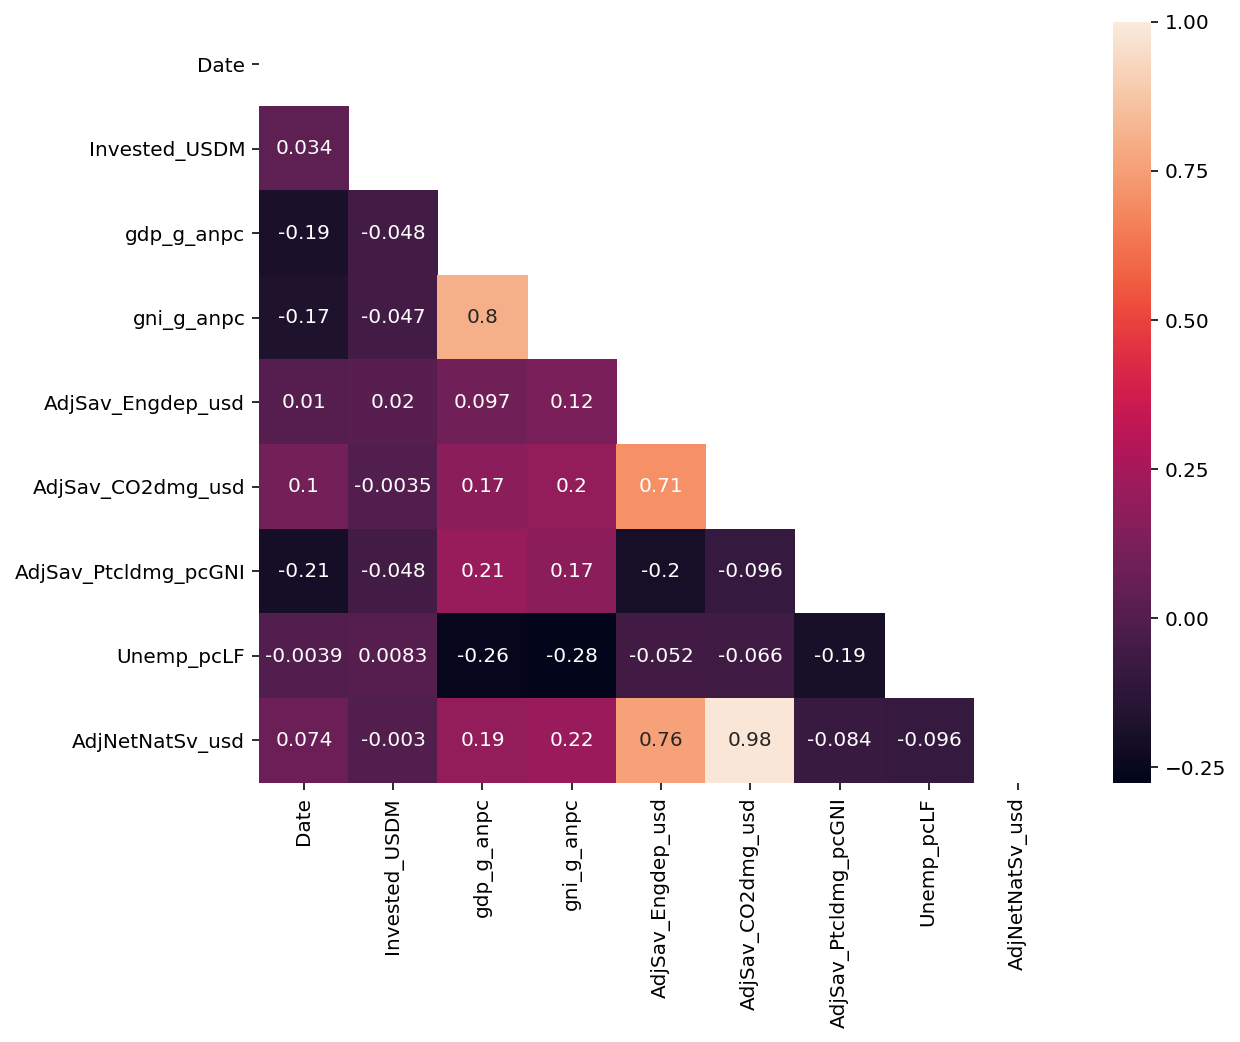

In [256]:
fig, ax = plt.subplots(figsize=(9, 7))
mask = np.zeros_like(X2.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(X2.corr(), mask=mask, annot=True, ax=ax)

plt.xticks(rotation=90)
plt.show()

fig.savefig('Eng_correlations.pdf', bbox_inches='tight')

## Train_test Splitting:

Creating train & test set based on year of 2015 to split data in near 80/20 fashion: 2001:2015 - 2015:2017.
Value_counts reveal a greater concentration of data was collected since 2015 justifying the split

In [11]:
X2.Date.value_counts()

2017    871
2016    810
2015    703
2014    698
2013    612
2012    566
2010    529
2011    491
2009    423
2008    255
2007    229
2005    183
2006    169
2004    167
2000    123
2003    121
2002    120
2001    108
Name: Date, dtype: int64

In [13]:
X_train = X2[X2.Date < 2015]

In [14]:
X_test = X2[X2.Date >= 2015]

Creating 2 different target variables to experiment predicting a continuous & categorical variable using regression and classification respectively 


Regression target: 

In [15]:
yr_train = X_train.pop('Invested_USDM')

In [16]:
yr_test = X_test.pop('Invested_USDM')

Regression baseline, in millions $

In [17]:
yr_train.mean()

25.918922987067255

Checking values at each quartile, representing amount invested in millions of dollars: 

In [370]:
np.percentile(yr_train, 25), yr_train.median(), np.percentile(yr_train, 75)

(0.041325, 0.3923, 10.561)

The classification target is defined by the four possible quartiles of investment received by each project: 

    0 : project belongs to the lowest quartile, Q1, ie 25% of projects having received smallest investment

    1 : project belongs to the second quartile, Q2, ie 25% of projects having received investment with a maximum of the median yet more than Q1

    2 : project belongs to the third quartile, Q3, ie 25% of projects having received the median investment quantity as a minimum

    3: project belongs to the fourth and highest quartile, Q4, ie 25 % projects having received the greatest investment quantity

Classification target

In [19]:
yc_train = yr_train.apply(lambda x: '0' if x <= np.percentile(yr_train, 25) else 
         ('1' if x <= yr_train.median() else ('2' if x <= np.percentile(yr_train, 75) else '3')))

In [20]:
yc_test = yr_test.apply(lambda x: '0' if x <= np.percentile(yr_test, 25) else 
         ('1' if x <= yr_test.median() else ('2' if x <= np.percentile(yr_test, 75) else '3')))

In [21]:
yc_train.value_counts(normalize=True)

3    0.250104
0    0.250104
2    0.249896
1    0.249896
Name: Invested_USDM, dtype: float64

In [381]:
yc_train.median()

1.5

In [384]:
yc_train.mean()

1.5

In [291]:
X_test.columns

Index(['Country', 'Project', 'Date', 'Investor', 'Technology', 'Asset Class',
       'gdp_g_anpc', 'gni_g_anpc', 'AdjSav_Engdep_usd', 'AdjSav_CO2dmg_usd',
       'AdjSav_Ptcldmg_pcGNI', 'Unemp_pcLF', 'AdjNetNatSv_usd', 'Year'],
      dtype='object')

Converting sets in an attempt to troubleshoot an error while performing NLP on the 'Project' column. 
("Vectorizer can't take arrays") 

In [22]:
yc_test = pd.Series(yc_test)
yc_train = pd.Series(yc_train)

In [23]:
yc_train = yc_train.astype(int)
yc_test = yc_test.astype(int)

In [24]:
yr_test = pd.Series(yr_test)
yr_train = pd.Series(yr_train)

## Transforming columns

Checking whether most categorical values can be encoded, notably curious per Asset Classes: 

In [369]:
X_train['Asset Class'].unique().tolist()

['Grant',
 'Loan',
 'Other Official Flows (non Export Credit)',
 'Equity Investment',
 'Credit line',
 'Insurance',
 'Guarantee']

Prepping the "Project" description column to perform NLP and extract insights from its text. Before stemming its tokens for vectorization, I must first join all words from each project's text into a list to iterate over. 

In [25]:
ps = PorterStemmer()
lemmatizer = WordNetLemmatizer()

words = []
for x in X_train.Project: 
    words.append(x.split(' '))
    
flat_list = [item for sublist in words for item in sublist]

stemmed_text = []
for token in flat_list:
     stemmed_text.append(ps.stem(token)) 
stemmed_text

lemma_text = []
for token in flat_list:
     lemma_text.append(lemmatizer.lemmatize(token))


I add different languages to the stopwords (corresponding to major projects' origin: namely North & South America and Europe) in addition to terms explicitly pertaining to Renewable Energies, filtering these out for more insight. After a first trial, I also decide to block out digits as done by 'num_list'. This required I run a first very basic column vectorization as performed in the first cell below:  

In [26]:
tfidf = TfidfVectorizer(strip_accents='unicode', ngram_range=(1, 1))
X_all = tfidf.fit_transform(stemmed_text)
columns = tfidf.get_feature_names()

In [27]:
numlist = [word for word in columns if re.match('\d+', word)]
stop = stopwords.words('english') + stopwords.words('french') + stopwords.words('spanish') + stopwords.words('portuguese')
stop += ['tc', 'ii', 'de', 'ab', 'abc', 'cc', 'énergie', 'energy', 'energies', 'project', 'fk', 'renewable', 'renouvelable',
         'renewables', 'power']
stop += numlist


I proceed with the set up of the Column Transformer. This pipeline of pipelines enables the simultaneous transformation of all datasets' different data types. I prepare 3 pipelines here referring to numerical, categorical and linguistic features to perform Standard Scaling, OneHotEncoding and TFIDF respectively.

Note I actually created 2 preprocessing pipes specific to classification and regression. The difference lies in that NLP features are determined based on how well they performed in either a basic classification (Logistic Regression) or regression task (Linear Regression). Different targets (continuous vs categorical) result in different optimal hyperparameters. 

In [28]:
numeric_features = ['gdp_g_anpc', 'gni_g_anpc', 'AdjSav_Engdep_usd', 'AdjSav_CO2dmg_usd',
       'AdjSav_Ptcldmg_pcGNI', 'Unemp_pcLF', 'AdjNetNatSv_usd']
numeric_transformer = Pipeline(steps=[
   ('scaler', StandardScaler())])

categorical_features = ['Country', 'Date', 'Investor', 'Technology', 'Asset Class']
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

nlp_features = 'Project'

clnlp_transformer = Pipeline(steps=[ #These features come from section 1.4's param_grid2, changed for smooth reruns
     ('Tfidf', TfidfVectorizer(stop_words = stop, use_idf=True, smooth_idf=True, strip_accents ='unicode',
                        max_df = 0.7, max_features= 600, min_df= 0.001, ngram_range = (1, 2)))])

rnlp_transformer = Pipeline(steps=[ #Below features found from 1.4's param_grid8, changed for smooth reruns
    ('Tfidf', TfidfVectorizer(stop_words = stop, use_idf=True, smooth_idf=True, strip_accents ='unicode', 
                            max_features = 20, max_df = 0.001, ngram_range = (1, 1)))])

clf_preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('nlp', clnlp_transformer, nlp_features)])

                            
reg_preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('nlp', rnlp_transformer, nlp_features)])

Anticipating the later stages studying feature importance, I manually extract features which result from TFIDF and OneHotEncoding: 

In [30]:
cl_tvec = TfidfVectorizer(stop_words = stop, use_idf=True, smooth_idf=True, strip_accents ='unicode',
                        max_df = 0.7, max_features= 600, min_df= 0.001, ngram_range = (1, 2))

cl_text = cl_tvec.fit_transform(X_train.Project)

Cltext_df = pd.DataFrame(cl_text.todense(),
                  columns=cl_tvec.get_feature_names())
Cltext_df.transpose().sort_values(0, ascending=False).transpose()

cl_nlpfeatures = cl_tvec.get_feature_names()

In [39]:
onehot = OneHotEncoder(handle_unknown='ignore')

hotties = onehot.fit_transform(X_train[categorical_features])

hot_df = pd.DataFrame(hotties.todense(),
                  columns=onehot.get_feature_names())

hot_df.transpose().sort_values(0, ascending=False).transpose()

hot_features = onehot.get_feature_names()

This 'all feature' list is necessary for section 2.2, figuring out feature importance:

In [40]:
all_features = list(hot_features) + list(cl_nlpfeatures) + numeric_features

While these actually proved unnecessary as I dropped regression given its poor results, I nonetheless extracted its expressive features: 

In [31]:
r_tvec = TfidfVectorizer(stop_words = stop, use_idf=True, smooth_idf=True, strip_accents ='unicode', 
                            max_features = 20, max_df = 0.001, ngram_range = (1, 1))

r_text = r_tvec.fit_transform(X_train.Project)

Rtext_df = pd.DataFrame(r_text.todense(),
                  columns=r_tvec.get_feature_names())
Rtext_df.transpose().sort_values(0, ascending=False).transpose()

rg_nlpfeatures = r_tvec.get_feature_names()

Crucial final step: transforming train & test splits by target type to integrate the Column Transformations

In [32]:
train_clX = clf_preprocessor.fit_transform(X_train)
test_clX = clf_preprocessor.transform(X_test)

In [33]:
train_rX = reg_preprocessor.fit_transform(X_train)
test_rX = reg_preprocessor.transform(X_test)

## TF-IDF Trial searches: 

Gridsearching through multiple TFIDF features, in a quest for the one that would best perform on an initial Logistic Regression. I boosted the two best ones to the top of the list. Can scroll down to discover which features were played with: 

In [303]:
param_grid2 = {
    'preprocessor__nlp__Tfidf__max_df' : [0.5, 0.6, 0.7, 0.75],
    'preprocessor__nlp__Tfidf__max_features': [200, 300, 400, 500, 600],
    'preprocessor__nlp__Tfidf__min_df': [0.001, 0.0015, 0.0025, 0.005],
    'preprocessor__nlp__Tfidf__ngram_range':[(1,2)]}

grid_search = GridSearchCV(pipe, param_grid2, cv=10, iid=False, verbose=1)
grid_search.fit(X_train, yc_train)

print(("best logistic regression from grid search: %.3f"
       % grid_search.score(X_test, yc_test)))

print('Tfdidf params for best score: ', grid_search.best_params_)

print("Test score:", grid_search.score(X_test, yc_test))

Fitting 10 folds for each of 60 candidates, totalling 600 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:  4.3min finished


best logistic regression from grid search: 0.549
Tfdidf params for best score:  {'preprocessor__nlp__Tfidf__max_df': 0.7, 'preprocessor__nlp__Tfidf__max_features': 600, 'preprocessor__nlp__Tfidf__min_df': 0.001, 'preprocessor__nlp__Tfidf__ngram_range': (1, 2)}
Test score: 0.549496644295302


In [343]:
param_grid8 = {
      #'preprocessor__num__scaler__strategy': ['mean', 'median'],
    'preprocessor__nlp__Tfidf__max_df' : [0.001, 0.1],
    'preprocessor__nlp__Tfidf__max_features': [10, 20, 30, 40, 50],
    #'preprocessor__nlp__Tfidf__min_df': [0.0009, 0.0025, 0.003, 0.004],
    'preprocessor__nlp__Tfidf__ngram_range':[(1,1), (1,2)],
#     'classifier__C': [0.1, 1.0, 10, 100],
#     'classifier__solver': ['liblinear', 'lbfgs']
#Removed all None from max/mindf & features
}

Rgrid_search6 = GridSearchCV(reg_pipe, param_grid8, cv=10, iid=False, verbose=1)
Rgrid_search6.fit(X_train, yr_train)

print(("best linear regression from grid search: %.3f"
       % Rgrid_search6.score(X_test, yr_test)))

print('Tfdidf params for best score: ', Rgrid_search6.best_params_)

print("Test score:", Rgrid_search6.score(X_test, yr_test))

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  1.3min finished


best linear regression from grid search: 0.240
Tfdidf params for best score:  {'preprocessor__nlp__Tfidf__max_df': 0.001, 'preprocessor__nlp__Tfidf__max_features': 20, 'preprocessor__nlp__Tfidf__ngram_range': (1, 1)}
Test score: 0.23954067485018338


In [302]:
model = LogisticRegression(solver='liblinear', max_iter=1000, class_weight='balanced', multi_class= 'ovr') 


pipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', model)])

param_grid = {
      #'preprocessor__num__scaler__strategy': ['mean', 'median'],
    'preprocessor__nlp__Tfidf__max_df' : [0.75, 0.8, 0.9],
    'preprocessor__nlp__Tfidf__max_features': [60, 100, 200, 500, 1000, 10000, 50000],
    'preprocessor__nlp__Tfidf__min_df': [0.0025, 0.005, 0.01, 0.05],
    'preprocessor__nlp__Tfidf__ngram_range':[(1,1), (1,2), (2, 3)],
#     'classifier__C': [0.1, 1.0, 10, 100],
#     'classifier__solver': ['liblinear', 'lbfgs']
#Removed all None from max/mindf & features
}
#Add 0.6 for max_df? & 0.1 for mind_df

        
grid_search = GridSearchCV(pipe, param_grid, cv=10, iid=False, verbose=1)
grid_search.fit(X_train, yc_train)

print(("best logistic regression from grid search: %.3f"
       % grid_search.score(X_test, yc_test)))

print('Tfdidf params for best score: ', grid_search.best_params_)

print("Test score:", grid_search.score(X_test, yc_test))

# predictions_test = grid_search.predict(X_test)
# predictions_train = grid_search.predict(X_train)
# confusion = pd.DataFrame(confusion_matrix(y_test, predictions_test),
#              index=['True 1', 'True 2'],
#              columns=['p1','p2'])

# try:
#     probs = grid_search.predict_proba(X_test)[:, 1]
# except:
#     pass

# print(classification_report(y_test, predictions_test, digits=4 ))
# print(confusion)

Fitting 10 folds for each of 252 candidates, totalling 2520 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2520 out of 2520 | elapsed: 14.9min finished


best logistic regression from grid search: 0.549
Tfdidf params for best score:  {'preprocessor__nlp__Tfidf__max_df': 0.75, 'preprocessor__nlp__Tfidf__max_features': 500, 'preprocessor__nlp__Tfidf__min_df': 0.0025, 'preprocessor__nlp__Tfidf__ngram_range': (1, 2)}
Test score: 0.5490771812080537


In [325]:
#Testing tfidf for regression: 

lr = LinearRegression() 
# RandomForestClassifier,
# AdaBoost

reg_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', lr)])

param_grid2 = {
      #'preprocessor__num__scaler__strategy': ['mean', 'median'],
    'preprocessor__nlp__Tfidf__max_df' : [0.5, 0.6, 0.7, 0.75],
    'preprocessor__nlp__Tfidf__max_features': [200, 300, 400, 500, 600],
    'preprocessor__nlp__Tfidf__min_df': [0.001, 0.0015, 0.0025, 0.005],
    'preprocessor__nlp__Tfidf__ngram_range':[(1,2)]}

Rgrid_search = GridSearchCV(reg_pipe, param_grid2, cv=10, iid=False, verbose=1)
Rgrid_search.fit(X_train, yr_train)

print(("best linear regression from grid search: %.3f"
       % Rgrid_search.score(X_test, yr_test)))

print('Tfdidf params for best score: ', Rgrid_search.best_params_)

print("Test score:", Rgrid_search.score(X_test, yr_test))

Fitting 10 folds for each of 80 candidates, totalling 800 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:  6.7min finished


best logistic regression from grid search: 0.180
Tfdidf params for best score:  {'preprocessor__nlp__Tfidf__max_df': 0.5, 'preprocessor__nlp__Tfidf__max_features': 200, 'preprocessor__nlp__Tfidf__min_df': 0.005, 'preprocessor__nlp__Tfidf__ngram_range': (1, 2)}
Test score: 0.18021852345003697


In [327]:
lr = LinearRegression() 
# RandomForestClassifier,
# AdaBoost

reg_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', lr)])

param_grid4 = {
      #'preprocessor__num__scaler__strategy': ['mean', 'median'],
    'preprocessor__nlp__Tfidf__max_df' : [0.5, 0.6, 0.75],
    'preprocessor__nlp__Tfidf__max_features': [60, 100, 200, 300],
    'preprocessor__nlp__Tfidf__min_df': [0.0025, 0.003, 0.005, 0.01],
    'preprocessor__nlp__Tfidf__ngram_range':[(1,1), (1,2)],
#     'classifier__C': [0.1, 1.0, 10, 100],
#     'classifier__solver': ['liblinear', 'lbfgs']
#Removed all None from max/mindf & features
}

Rgrid_search2 = GridSearchCV(reg_pipe, param_grid4, cv=10, iid=False, verbose=1)
Rgrid_search2.fit(X_train, yr_train)

print(("best linear regression from grid search: %.3f"
       % Rgrid_search2.score(X_test, yr_test)))

print('Tfdidf params for best score: ', Rgrid_search2.best_params_)

print("Test score:", Rgrid_search2.score(X_test, yr_test))

Fitting 10 folds for each of 96 candidates, totalling 960 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 960 out of 960 | elapsed:  5.2min finished


best linear regression from grid search: 0.201
Tfdidf params for best score:  {'preprocessor__nlp__Tfidf__max_df': 0.5, 'preprocessor__nlp__Tfidf__max_features': 60, 'preprocessor__nlp__Tfidf__min_df': 0.01, 'preprocessor__nlp__Tfidf__ngram_range': (1, 1)}
Test score: 0.20118711408927825


In [329]:
param_grid5 = {
      #'preprocessor__num__scaler__strategy': ['mean', 'median'],
    #'preprocessor__nlp__Tfidf__max_df' : [None, 0.5, 0.55],
    'preprocessor__nlp__Tfidf__max_features': [40, 50, 60, 70],
    'preprocessor__nlp__Tfidf__min_df': [0.0025, 0.003, 0.005, 0.01, 0.02],
    'preprocessor__nlp__Tfidf__ngram_range':[(1,1), (1,2)],
#     'classifier__C': [0.1, 1.0, 10, 100],
#     'classifier__solver': ['liblinear', 'lbfgs']
#Removed all None from max/mindf & features
}

Rgrid_search3 = GridSearchCV(reg_pipe, param_grid5, cv=10, iid=False, verbose=1)
Rgrid_search3.fit(X_train, yr_train)

print(("best linear regression from grid search: %.3f"
       % Rgrid_search3.score(X_test, yr_test)))

print('Tfdidf params for best score: ', Rgrid_search3.best_params_)

print("Test score:", Rgrid_search3.score(X_test, yr_test))

Fitting 10 folds for each of 40 candidates, totalling 400 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:  1.9min finished


best linear regression from grid search: 0.207
Tfdidf params for best score:  {'preprocessor__nlp__Tfidf__max_features': 40, 'preprocessor__nlp__Tfidf__min_df': 0.003, 'preprocessor__nlp__Tfidf__ngram_range': (1, 1)}
Test score: 0.20713953032970644


In [336]:
param_grid6 = {
      #'preprocessor__num__scaler__strategy': ['mean', 'median'],
    #'preprocessor__nlp__Tfidf__max_df' : [None, 0.5, 0.55],
    'preprocessor__nlp__Tfidf__max_features': [10, 20, 30, 40, 50],
    'preprocessor__nlp__Tfidf__min_df': [0.001, 0.0025, 0.003, 0.004],
    'preprocessor__nlp__Tfidf__ngram_range':[(1,1)],
#     'classifier__C': [0.1, 1.0, 10, 100],
#     'classifier__solver': ['liblinear', 'lbfgs']
#Removed all None from max/mindf & features
}

Rgrid_search4 = GridSearchCV(reg_pipe, param_grid6, cv=10, iid=False, verbose=1)
Rgrid_search4.fit(X_train, yr_train)

print(("best linear regression from grid search: %.3f"
       % Rgrid_search4.score(X_test, yr_test)))

print('Tfdidf params for best score: ', Rgrid_search4.best_params_)

print("Test score:", Rgrid_search4.score(X_test, yr_test))

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  1.3min finished


best linear regression from grid search: 0.229
Tfdidf params for best score:  {'preprocessor__nlp__Tfidf__max_features': 10, 'preprocessor__nlp__Tfidf__min_df': 0.001, 'preprocessor__nlp__Tfidf__ngram_range': (1, 1)}
Test score: 0.2292510653546006


In [344]:
#It seems score stalls whether or not max/min_df are kept or  not, therefore: 

reg_tfidf = TfidfVectorizer(stop_words = stop, use_idf=True, smooth_idf=True, strip_accents ='unicode', 
                            max_features = 20, max_df = 0.001, ngram_range = (1, 1))

In [335]:
#Try removing min_df too? 
param_grid9 = {
      #'preprocessor__num__scaler__strategy': ['mean', 'median'],
    'preprocessor__nlp__Tfidf__max_df' : [0.001, 0.1],
    'preprocessor__nlp__Tfidf__max_features': [10, 20, 30, 40, 50],
    'preprocessor__nlp__Tfidf__min_df': [0.0009, 0.0025, 0.003, 0.004],
    'preprocessor__nlp__Tfidf__ngram_range':[(1,1)],
#     'classifier__C': [0.1, 1.0, 10, 100],
#     'classifier__solver': ['liblinear', 'lbfgs']
#Removed all None from max/mindf & features
}

Rgrid_search4 = GridSearchCV(reg_pipe, param_grid7, cv=10, iid=False, verbose=1)
Rgrid_search4.fit(X_train, yr_train)

print(("best linear regression from grid search: %.3f"
       % Rgrid_search4.score(X_test, yr_test)))

print('Tfdidf params for best score: ', Rgrid_search4.best_params_)

print("Test score:", Rgrid_search4.score(X_test, yr_test))

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   59.8s finished


best linear regression from grid search: 0.215
Tfdidf params for best score:  {'preprocessor__nlp__Tfidf__max_df': 0.5, 'preprocessor__nlp__Tfidf__min_df': 0.02, 'preprocessor__nlp__Tfidf__ngram_range': (1, 1)}
Test score: 0.21501613548377707


## Searching for Optimal Classification Model: 

In an attempt to make the process as thorough and autonomous as possible, I decided to create batches of models and parameter grids to run through simultaneously. Note I decided to leave DecisionTrees out in favor of Ensemble Methods. Also separate classifiers and regressors as they relate to different datasets

In [41]:
classifiers = [
    KNeighborsClassifier(),
    LogisticRegression(),
    #DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(), 
    GaussianNB(), 
    BernoulliNB(), 
    svm.SVC(probability = True)
    ]

regressors = [ElasticNet(max_iter = 100000),
             #DecisionTreeRegressor(), 
             RandomForestRegressor(), 
             AdaBoostRegressor(),
             GradientBoostingRegressor(),
            svm.SVR()
             ]


In [42]:
knn_params= {
    'n_neighbors' : [2, 3, 4, 5, 6],
    'weights' : ['distance', 'uniform']}

logreg_params = {'C': np.logspace(-5, 5, 15),
'penalty': ['l1', 'l2'],
'fit_intercept': [True, False]}


rf_params = {'bootstrap': [True],
'max_depth': [80, 90, 100, 110], 
'max_features': [2, 3],
'min_samples_leaf': [3, 4, 5],
'min_samples_split': [8, 10, 12],
'n_estimators': [1000]}


ada_params = {'n_estimators': [50, 100, 200, 500],
              'base_estimator' : [DecisionTreeClassifier(max_depth=2), DecisionTreeClassifier(max_depth=3),
                                  DecisionTreeClassifier(max_depth=4)]}

Rada_params = {'n_estimators': [50, 100, 200, 500],
              'base_estimator' : [DecisionTreeRegressor(max_depth=2), DecisionTreeRegressor(max_depth=3),
                                  DecisionTreeRegressor(max_depth=4)]}

gb_params = {'n_estimators': [200, 500, 1000],
'learning_rate': [0.02, 0.05],
'max_depth': [1, 2],
'min_samples_leaf': [5,10],
'min_samples_split': [5,10]} 

clf_grids = [knn_params, logreg_params, rf_params, ada_params, gb_params] #dt_params

enet_params = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
'l1_ratio': np.linspace(0.0001, 1.0, 20)}

reg_grids = [enet_params, rf_params, Rada_params, gb_params] #dt_params,

The following list comprehensions allow me to loop through each model/grid pairs. 
'Model_gs' consist of classifiers whereas 'rg_grids' consist of regression models

In [43]:
model_gs = zip(classifiers[:-3], clf_grids)

In [44]:
model_grids = [(i, m) for i, m in model_gs]

In [45]:
reg_mogs = zip(regressors[:-1], reg_grids)

In [438]:
rg_grids = [(r, g) for r, g in reg_mogs]

The looping begins! 
I initialize the overarching 'clf' dictionary which will collect the best model resulting from each loop's gridsearch. This will then enable me to efficiently retrieve the best performing models.

In [46]:
clf = {}
for model, grid in tqdm(model_grids):
    
    temp_clf = {}
    gs = GridSearchCV(model, param_grid = grid, cv=5, n_jobs= 1, verbose=1, scoring = 'accuracy')
    gs.fit(train_clX, yc_train)

    gs_best = gs.best_estimator_
    
   #gs_best.fit(train_X, yc_train)
    gs_optCV = gs.best_score_ 
    gs_CV = cross_val_score(gs_best, train_clX, yc_train, cv = 5).mean()
    test_score = gs.score(test_clX, yc_test)
    gs_params = gs.best_params_

    temp_clf['Model'] = gs_best
    temp_clf['Mean CV'] = gs_CV
    temp_clf['Test_score'] = test_score

    clf[str(model)] = temp_clf 

  0%|          | 0/5 [00:00<?, ?it/s][Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   10.2s finished
 20%|██        | 1/5 [00:12<00:48, 12.12s/it][Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  6.5min finished
 40%|████      | 2/5 [06:40<06:14, 124.87s/it][Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed: 23.3min finished
 60%|██████    | 3/5 [30:22<17:08, 514.27s/it][Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  3.7min finished
 80%|████████  | 4/5 [35:10<07:26, 446.39s/it][Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed: 71.1min finished
100%|██████████| 5/5 [1:47:05<00:00, 1285.19s/it]


Exploring SVC's results separately to optimize time. Indeed, gridsearching SVCs is a lengthy process which I preferred to do separately. 
I proceed similarly than above: creating a dictionary with the loop's results which I then add to the clf master dictionary.

In [97]:
temp_svc = {}

#Below are the parameters returned from the gridsearch commented out below. Replaced for rerun
svc = svm.SVC(C=0.1668100537200059, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1e-05, kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

# svc_grid = {'gamma' : np.logspace(-5, 2, 10),
#             'C' : np.logspace(-3, 2, 10), 
#             'kernel' : ['rbf', 'sigmoid', 'linear', 'poly']}

# gs = GridSearchCV(svc, svc_grid, cv=3,
#                     scoring='accuracy', verbose=1, n_jobs=2)
svc.fit(train_clX, yc_train)
gs_optCV = gs.best_score_ 
gs_CV = cross_val_score(svc, train_clX, yc_train, cv = 5).mean()
test_score = svc.score(test_clX, yc_test)

temp_svc['Model'] = svc
temp_svc['Mean CV'] = gs_CV
temp_svc['Test_score'] = test_score

clf['SVC'] = temp_svc

In [98]:
temp_svc

{'Model': SVC(C=0.1668100537200059, cache_size=200, class_weight=None, coef0=0.0,
     decision_function_shape='ovr', degree=3, gamma=1e-05, kernel='linear',
     max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
     verbose=False),
 'Mean CV': 0.4972546936463983,
 'Test_score': 0.5444630872483222}

Exploring a Neural Network separately for the same reason as above. The same process is also followed

In [56]:
temp_nnet = {}

nnet = MLPClassifier()

nn_grid = {'solver' : ['adam','lbfgs','sgd'],
            'alpha' : [10**(0)],
            'hidden_layer_sizes' : [1, 2, 4],
            'activation' : ['relu', 'tanh'],
           #'learning rate' : [0.1, 0.001, 0.01],
            'random_state' : [1],
            'batch_size' : [5, 10, 20, 50, 100],
            'max_iter' : [1000] }

nngs = GridSearchCV(nnet, nn_grid, cv = 3, verbose=1, n_jobs =1)
nngs.fit(train_clX, yc_train)
nngs_best = nngs.best_estimator_
nngs_CV = cross_val_score(nngs_best, train_clX, yc_train, cv = 5).mean()
test_score = nngs_best.score(test_clX, yc_test)

temp_nnet['Model'] = nngs_best
temp_nnet['Mean CV'] = nngs_CV
temp_nnet['Test_score'] = test_score

#clf['NNet'] = temp_nnet
print(test_score)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 324 out of 324 | elapsed: 61.0min finished


0.48196308724832215


In [63]:
nngs.best_params_

{'activation': 'relu',
 'alpha': 1,
 'batch_size': 20,
 'hidden_layer_sizes': 2,
 'max_iter': 500,
 'random_state': 1,
 'solver': 'sgd'}

Finally, running Naive Bayes models. They're also done separately as they don't admit of gridsearches and the sparse matrix dataset must be unravelled for it to run. Results are also added to the clf dictionary.

In [47]:
for classifier in tqdm(classifiers[-3:-1]):
    temp_dict = {}

    model = classifier
    dense_train = train_clX.toarray()
    dense_test = test_clX.toarray()
    model.fit(dense_train, yc_train)
    meancv = cross_val_score(model, dense_train, yc_train, cv=5).mean()
    test_score = model.score(dense_test, yc_test)

    temp_dict['Model'] = model
    temp_dict['Mean CV'] = meancv
    temp_dict['Test_score'] = test_score

    clf[str(classifier)] = temp_dict
        

100%|██████████| 2/2 [00:01<00:00,  1.86it/s]


I transform the dictionary into a dataframe for readability:

In [71]:
results_clf = pd.DataFrame(clf)

In [95]:
results_clf

,"KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',\n metric_params=None, n_jobs=None, n_neighbors=5, p=2,\n weights='uniform')","LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, l1_ratio=None, max_iter=100,\n multi_class='warn', n_jobs=None, penalty='l2',\n random_state=None, solver='warn', tol=0.0001, verbose=0,\n warm_start=False)","RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',\n max_depth=None, max_features='auto', max_leaf_nodes=None,\n min_impurity_decrease=0.0, min_impurity_split=None,\n min_samples_leaf=1, min_samples_split=2,\n min_weight_fraction_leaf=0.0, n_estimators='warn',\n n_jobs=None, oob_score=False, random_state=None,\n verbose=0, warm_start=False)","AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,\n n_estimators=50, random_state=None)","GradientBoostingClassifier(criterion='friedman_mse', init=None,\n learning_rate=0.1, loss='deviance', max_depth=3,\n max_features=None, max_leaf_nodes=None,\n min_impurity_decrease=0.0, min_impurity_split=None,\n min_samples_leaf=1, min_samples_split=2,\n min_weight_fraction_leaf=0.0, n_estimators=100,\n n_iter_no_change=None, presort='auto',\n random_state=None, subsample=1.0, tol=0.0001,\n validation_fraction=0.1, verbose=0,\n warm_start=False)","GaussianNB(priors=None, var_smoothing=1e-09)","BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)",SVC
Model,"KNeighborsClassifier(algorithm='auto', leaf_si...","LogisticRegression(C=0.19306977288832497, clas...","(DecisionTreeClassifier(class_weight=None, cri...","(DecisionTreeClassifier(class_weight=None, cri...",([DecisionTreeRegressor(criterion='friedman_ms...,"GaussianNB(priors=None, var_smoothing=1e-09)","BernoulliNB(alpha=1.0, binarize=0.0, class_pri...","SVC(C=0.1668100537200059, cache_size=200, clas..."
Mean CV,0.407586,0.505397,0.525641,0.437846,0.531868,0.306709,0.527097,0.497255
Test_score,0.497064,0.565856,0.529782,0.48448,0.525587,0.429111,0.53146,0.544463


In [120]:
clf_results = results_clf.copy()

,"KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',\n metric_params=None, n_jobs=None, n_neighbors=5, p=2,\n weights='uniform')","LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, l1_ratio=None, max_iter=100,\n multi_class='warn', n_jobs=None, penalty='l2',\n random_state=None, solver='warn', tol=0.0001, verbose=0,\n warm_start=False)","RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',\n max_depth=None, max_features='auto', max_leaf_nodes=None,\n min_impurity_decrease=0.0, min_impurity_split=None,\n min_samples_leaf=1, min_samples_split=2,\n min_weight_fraction_leaf=0.0, n_estimators='warn',\n n_jobs=None, oob_score=False, random_state=None,\n verbose=0, warm_start=False)","AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,\n n_estimators=50, random_state=None)","GradientBoostingClassifier(criterion='friedman_mse', init=None,\n learning_rate=0.1, loss='deviance', max_depth=3,\n max_features=None, max_leaf_nodes=None,\n min_impurity_decrease=0.0, min_impurity_split=None,\n min_samples_leaf=1, min_samples_split=2,\n min_weight_fraction_leaf=0.0, n_estimators=100,\n n_iter_no_change=None, presort='auto',\n random_state=None, subsample=1.0, tol=0.0001,\n validation_fraction=0.1, verbose=0,\n warm_start=False)","GaussianNB(priors=None, var_smoothing=1e-09)","BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)"
Model,"KNeighborsClassifier(algorithm='auto', leaf_si...","LogisticRegression(C=0.19306977288832497, clas...","(DecisionTreeClassifier(class_weight=None, cri...","(DecisionTreeClassifier(class_weight=None, cri...",([DecisionTreeRegressor(criterion='friedman_ms...,"GaussianNB(priors=None, var_smoothing=1e-09)","BernoulliNB(alpha=1.0, binarize=0.0, class_pri..."
Mean CV,0.407586,0.505397,0.525641,0.437846,0.531868,0.306709,0.527097
Test_score,0.497064,0.565856,0.529782,0.48448,0.525587,0.429111,0.53146


In [123]:
svcdf = pd.DataFrame(temp_svc, index = ['SVC'])
svcdf = svcdf.T 

In [125]:
clf_results = pd.concat([clf_results, svcdf], axis=1)
clf_results

,"KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',\n metric_params=None, n_jobs=None, n_neighbors=5, p=2,\n weights='uniform')","LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, l1_ratio=None, max_iter=100,\n multi_class='warn', n_jobs=None, penalty='l2',\n random_state=None, solver='warn', tol=0.0001, verbose=0,\n warm_start=False)","RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',\n max_depth=None, max_features='auto', max_leaf_nodes=None,\n min_impurity_decrease=0.0, min_impurity_split=None,\n min_samples_leaf=1, min_samples_split=2,\n min_weight_fraction_leaf=0.0, n_estimators='warn',\n n_jobs=None, oob_score=False, random_state=None,\n verbose=0, warm_start=False)","AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,\n n_estimators=50, random_state=None)","GradientBoostingClassifier(criterion='friedman_mse', init=None,\n learning_rate=0.1, loss='deviance', max_depth=3,\n max_features=None, max_leaf_nodes=None,\n min_impurity_decrease=0.0, min_impurity_split=None,\n min_samples_leaf=1, min_samples_split=2,\n min_weight_fraction_leaf=0.0, n_estimators=100,\n n_iter_no_change=None, presort='auto',\n random_state=None, subsample=1.0, tol=0.0001,\n validation_fraction=0.1, verbose=0,\n warm_start=False)","GaussianNB(priors=None, var_smoothing=1e-09)","BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)",SVC
Model,"KNeighborsClassifier(algorithm='auto', leaf_si...","LogisticRegression(C=0.19306977288832497, clas...","(DecisionTreeClassifier(class_weight=None, cri...","(DecisionTreeClassifier(class_weight=None, cri...",([DecisionTreeRegressor(criterion='friedman_ms...,"GaussianNB(priors=None, var_smoothing=1e-09)","BernoulliNB(alpha=1.0, binarize=0.0, class_pri...","SVC(C=0.1668100537200059, cache_size=200, clas..."
Mean CV,0.407586,0.505397,0.525641,0.437846,0.531868,0.306709,0.527097,0.497255
Test_score,0.497064,0.565856,0.529782,0.48448,0.525587,0.429111,0.53146,0.544463


Simplifying column names before transposing the matrix for better readability: 

In [126]:

cols_1 = clf_results.columns
cols_2 = ['KNN', 'LogReg', 'RandomForest', 'AdaBoost', 'GBoost', 'G_NB', 'B_NB', 'SVC']

clf_results.rename(
    columns={i:j for i,j in zip(cols_1, cols_2)}, inplace=True)

In [127]:
clf_results = clf_results.T
clf_results.columns

Index(['Model', 'Mean CV', 'Test_score'], dtype='object')

In [128]:
clf_results.rename(columns = {'Model': 'Params', 'Mean CV': 'Mean_CV'}, inplace=True)

In [129]:
clf_results

,Params,Mean_CV,Test_score
KNN,"KNeighborsClassifier(algorithm='auto', leaf_si...",0.407586,0.497064
LogReg,"LogisticRegression(C=0.19306977288832497, clas...",0.505397,0.565856
RandomForest,"(DecisionTreeClassifier(class_weight=None, cri...",0.525641,0.529782
AdaBoost,"(DecisionTreeClassifier(class_weight=None, cri...",0.437846,0.48448
GBoost,([DecisionTreeRegressor(criterion='friedman_ms...,0.531868,0.525587
G_NB,"GaussianNB(priors=None, var_smoothing=1e-09)",0.306709,0.429111
B_NB,"BernoulliNB(alpha=1.0, binarize=0.0, class_pri...",0.527097,0.53146
SVC,"SVC(C=0.1668100537200059, cache_size=200, clas...",0.497255,0.544463


In [358]:
clf_results.Params

KNN             KNeighborsClassifier(algorithm='auto', leaf_si...
LogReg          LogisticRegression(C=0.19306977288832497, clas...
RandomForest    (DecisionTreeClassifier(class_weight=None, cri...
AdaBoost        (DecisionTreeClassifier(class_weight=None, cri...
GBoost          ([DecisionTreeRegressor(criterion='friedman_ms...
SVC             SVC(C=100.0, cache_size=200, class_weight=None...
G_NB                 GaussianNB(priors=None, var_smoothing=1e-09)
B_NB            BernoulliNB(alpha=1.0, binarize=0.0, class_pri...
Name: Params, dtype: object

In [130]:
clf_results.sort_values(by = 'Test_score', ascending=False, inplace=True)

In [329]:
clf_results

,Params,Mean_CV,Test_score
LogReg,"LogisticRegression(C=0.19306977288832497, clas...",0.505397,0.565856
SVC,"SVC(C=0.1668100537200059, cache_size=200, clas...",0.497255,0.544463
B_NB,"BernoulliNB(alpha=1.0, binarize=0.0, class_pri...",0.527097,0.53146
RandomForest,"(DecisionTreeClassifier(class_weight=None, cri...",0.525641,0.529782
GBoost,([DecisionTreeRegressor(criterion='friedman_ms...,0.531868,0.525587
KNN,"KNeighborsClassifier(algorithm='auto', leaf_si...",0.407586,0.497064
AdaBoost,"(DecisionTreeClassifier(class_weight=None, cri...",0.437846,0.48448
G_NB,"GaussianNB(priors=None, var_smoothing=1e-09)",0.306709,0.429111


Will retain top 3 models for further investigation, collected in the top_clf dataframe: 

In [131]:
top_clf = clf_results[:3]

In [218]:
top_clf.Params[0]

LogisticRegression(C=0.19306977288832497, class_weight=None, dual=False,
                   fit_intercept=False, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In an attempt to check the consistency of the best performing models'accuracy, I run it 700 times. Its average score remains the same ensuring me of its not having occurred by chance and thus of this model's reliability: 

In [215]:
best_lg = top_clf.Params[0]
lg_scores = []
x = 0
while x < 700: 
    best_lg.fit(train_clX, yc_train)
    test_score = best_lg.score(test_clX, yc_test)
    lg_scores.append(test_score)
    x+=1
    
avg_tscore = (sum(lg_scores) / x)
avg_tscore

0.565855704697982

In [224]:
LogisticRegression().get_params().keys()

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])

## Regression Models: 

Ran on Google Colab for time efficiency: parallelized works. The same process as for classification running is performed. 

In [ ]:
regs = {}
for model, grid in tqdm(rg_grids):
    
    temp_regs = {}
    gs = GridSearch(model, param_grid = grid, cv=5, n_jobs= 1, verbose=1)
    gs.fit(train_X, yr_train)

    gs_best = gs.best_estimator_
    gs_optCV = gs.best_score_ 
    gs_CV = cross_val_score(gs_best, train_X, yr_train, cv = 5).mean()
    test_score = gs_best.score(test_X, yr_test)
    gs_params = gs.best_params_


    temp_regs['Model'] = gs_best
    temp_regs['Mean CV'] = gs_CV
    temp_regs['Test score'] = test_score
    
    regs[str(model)] = temp_regs

#     print(gs_best)
#     print("model score: %.3f" % test_score

#results_df[results_df.score.max()]

In [ ]:
model = svc.SVR()

temp_svr = {}
svr_grid = {'kernel': ['linear', 'rbf','poly'],
            'C':[1.5, 10],
            'gamma': [1e-7, 1e-4],
            'epsilon':[0.1,0.2,0.5,0.3]}

gs = GridSearchCV(model, svr_grid, cv=3,
                    scoring='accuracy', verbose=1, n_jobs=2)
gs.fit(train_X, yc_train)
gs_best = gs.best_estimator_
gs_optCV = gs.best_score_ 
gs_CV = cross_val_score(gs_best, train_X, yc_train, cv = 5).mean()
test_score = gs_best.score(test_X, yc_test)
gs_params = gs.best_params_


temp_svr['Model'] = gs_best
temp_svr['Mean CV'] = gs_CV
temp_svr['Test score'] = test_score

regs['SVR'] = temp_svr

In [339]:
rg_grids

[(ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
             max_iter=100000, normalize=False, positive=False, precompute=False,
             random_state=None, selection='cyclic', tol=0.0001, warm_start=False),
  {'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
   'l1_ratio': array([1.00000000e-04, 5.27263158e-02, 1.05352632e-01, 1.57978947e-01,
          2.10605263e-01, 2.63231579e-01, 3.15857895e-01, 3.68484211e-01,
          4.21110526e-01, 4.73736842e-01, 5.26363158e-01, 5.78989474e-01,
          6.31615789e-01, 6.84242105e-01, 7.36868421e-01, 7.89494737e-01,
          8.42121053e-01, 8.94747368e-01, 9.47373684e-01, 1.00000000e+00])}),
 (RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                        max_features='auto', max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_lea

In [ ]:
#Extract best model
results_reg = pd.DataFrame(regs)

In [265]:
#Simplifying column names before transposing the matrix for better readability: 
rcols_1 = results_reg.columns
rcols_2 = ['ENet','RandomForest', 'AdaBoost', 'GBoost', 'SVR']

results_reg.rename(
    columns={i:j for i,j in zip(cols_1, cols_2)}, inplace=True)

In [278]:
results_reg = results_reg.T
results_reg.columns

Index(['Model', 'Mean CV', 'Test score'], dtype='object')

In [324]:
results_reg.rename(columns = {'Model': 'Params','Test score' : 'Test_score', 'Mean CV': 'Mean_CV'}, inplace=True)

In [482]:
results_reg = pd.read_csv('/Users/valentinereltien/Desktop/IRENA/Regression_results.csv')

In [484]:
results_reg.sort_values(by='Test_score', ascending=False, inplace=True)

In [485]:
results_reg

,Params,Mean_CV,Test_score
3,"GradientBoostingRegressor(alpha=0.9, ccp_alpha...",0.301466,0.259860
2,AdaBoostRegressor(base_estimator=DecisionTreeR...,0.244407,0.239775
0,"ElasticNet(alpha=0.001, copy_X=True, fit_inter...",0.261836,0.231439
4,"SVR(C=10, cache_size=200, coef0=0.0, degree=3,...",0.225666,0.152384
1,"RandomForestRegressor(bootstrap=True, ccp_alph...",0.176794,0.101594


# Evaluating three best classification models: 

## Classification Report & Confusion Matrices : 

Looping through all best models to visualize their classification report on confusion matrix to gain insight into their alternative scores (namely precision & recall).

LogReg's Classification Report: 
               precision    recall  f1-score   support

           0     0.6055    0.6309    0.6179       596
           1     0.5199    0.5252    0.5225       596
           2     0.4674    0.2047    0.2847       596
           3     0.5978    0.9027    0.7193       596

    accuracy                         0.5659      2384
   macro avg     0.5477    0.5659    0.5361      2384
weighted avg     0.5477    0.5659    0.5361      2384

LogReg's Confusion Matrix: 
 AxesSubplot(0.125,0.125;0.62x0.755)


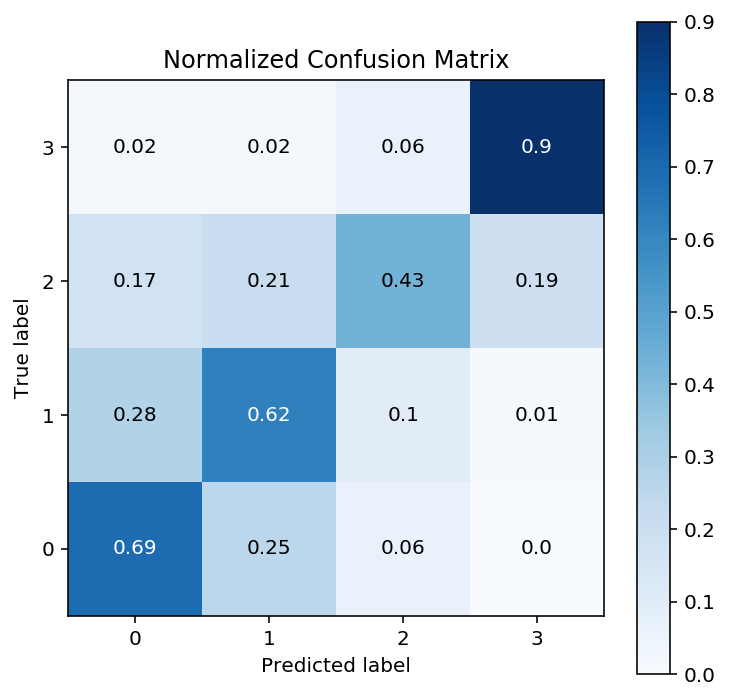

SVC's Classification Report: 
               precision    recall  f1-score   support

           0     0.6138    0.5654    0.5886       596
           1     0.4811    0.5134    0.4968       596
           2     0.3968    0.1644    0.2325       596
           3     0.5851    0.9346    0.7196       596

    accuracy                         0.5445      2384
   macro avg     0.5192    0.5445    0.5094      2384
weighted avg     0.5192    0.5445    0.5094      2384

SVC's Confusion Matrix: 
 AxesSubplot(0.125,0.125;0.62x0.755)


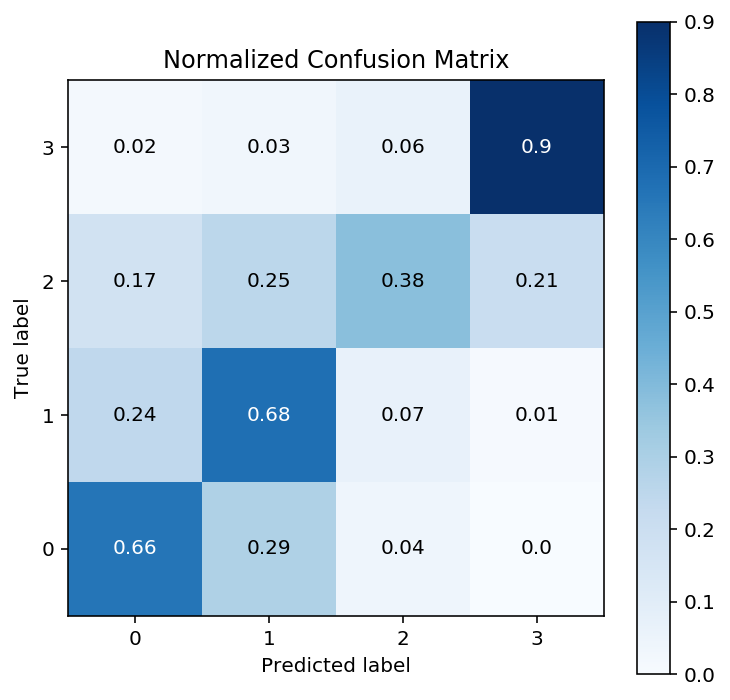

B_NB's Classification Report: 
               precision    recall  f1-score   support

           0     0.6270    0.5386    0.5794       596
           1     0.4711    0.4513    0.4610       596
           2     0.3700    0.2483    0.2972       596
           3     0.5871    0.8876    0.7067       596

    accuracy                         0.5315      2384
   macro avg     0.5138    0.5315    0.5111      2384
weighted avg     0.5138    0.5315    0.5111      2384

B_NB's Confusion Matrix: 
 AxesSubplot(0.125,0.125;0.62x0.755)


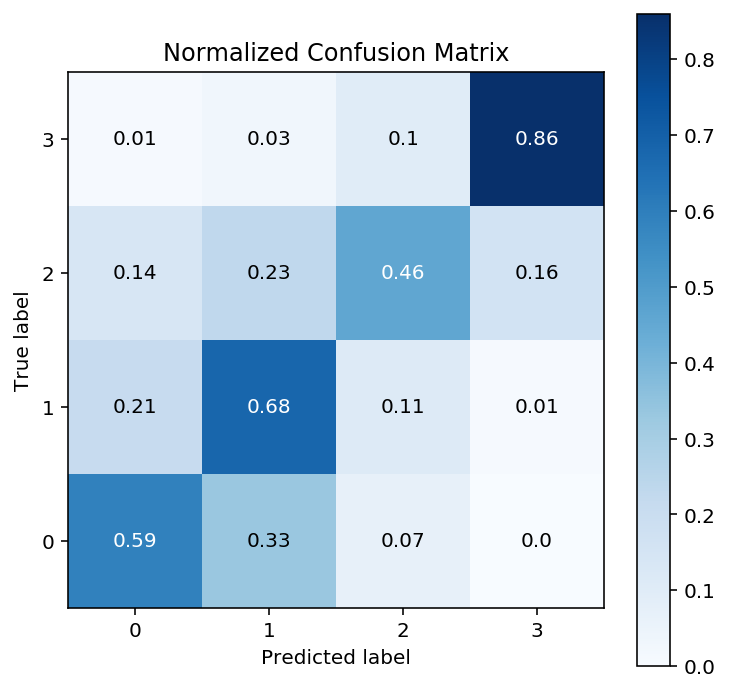

In [200]:
for i, clf in enumerate(top_clf.Params):
    pred_test = clf.predict(test_clX)
    pred_train = clf.predict(train_clX)

    confusion = skplt.metrics.plot_confusion_matrix(yc_train, pred_train, figsize = (6,6), normalize=True)
    
    try:
        probs = clf.predict_proba(test_X)[:, 1]
    except:
        pass

    print("{}'s Classification Report: \n".format(top_clf.index[i]), classification_report(yc_test, pred_test, digits=4 ))
    print("{}'s Confusion Matrix: \n".format(top_clf.index[i]), confusion)
    plt.ylim([-0.5, len(yc_train.unique())-0.5])
    plt.show()

## Figuring Logistic Regression's Features Importance:

In [261]:
top_clf

,Params,Mean_CV,Test_score
LogReg,"LogisticRegression(C=0.19306977288832497, clas...",0.505397,0.565856
SVC,"SVC(C=0.1668100537200059, cache_size=200, clas...",0.497255,0.544463
B_NB,"BernoulliNB(alpha=1.0, binarize=0.0, class_pri...",0.527097,0.53146


In [83]:
top_clf.Params

LogReg    LogisticRegression(C=0.19306977288832497, clas...
SVC       SVC(C=0.1668100537200059, cache_size=200, clas...
B_NB      BernoulliNB(alpha=1.0, binarize=0.0, class_pri...
Name: Params, dtype: object

'All features' called from section 1.3

In [134]:
all_features = list(hot_features) + list(cl_nlpfeatures) + numeric_features

Visualizing Logistic Regression's coefficients' feature importance for each of its 4 classes.

                               coef  abs_coef
afghanistan               -2.422538  2.422538
africa                    -1.226369  1.226369
developpement              1.169465  1.169465
development policy         1.169465  1.169465
x3_Solar energy           -1.102425  1.102425
x4_Insurance              -1.062983  1.062983
x3_Renewable Hydropower    0.976173  0.976173
promoting                 -0.955471  0.955471
windenergienutzung afrika -0.924725  0.924725
x3_Geothermal energy      -0.915080  0.915080
x2_WBG                     0.910467  0.910467
x2_OPIC                   -0.894059  0.894059
activities                -0.817743  0.817743
pims                      -0.772970  0.772970
x0_Kazakhstan             -0.748218  0.748218
x4_Grant                  -0.740956  0.740956
flandre occidentale       -0.724944  0.724944
x4_Credit line            -0.719240  0.719240
flandre                   -0.714090  0.714090
finnpartnership           -0.712009  0.712009


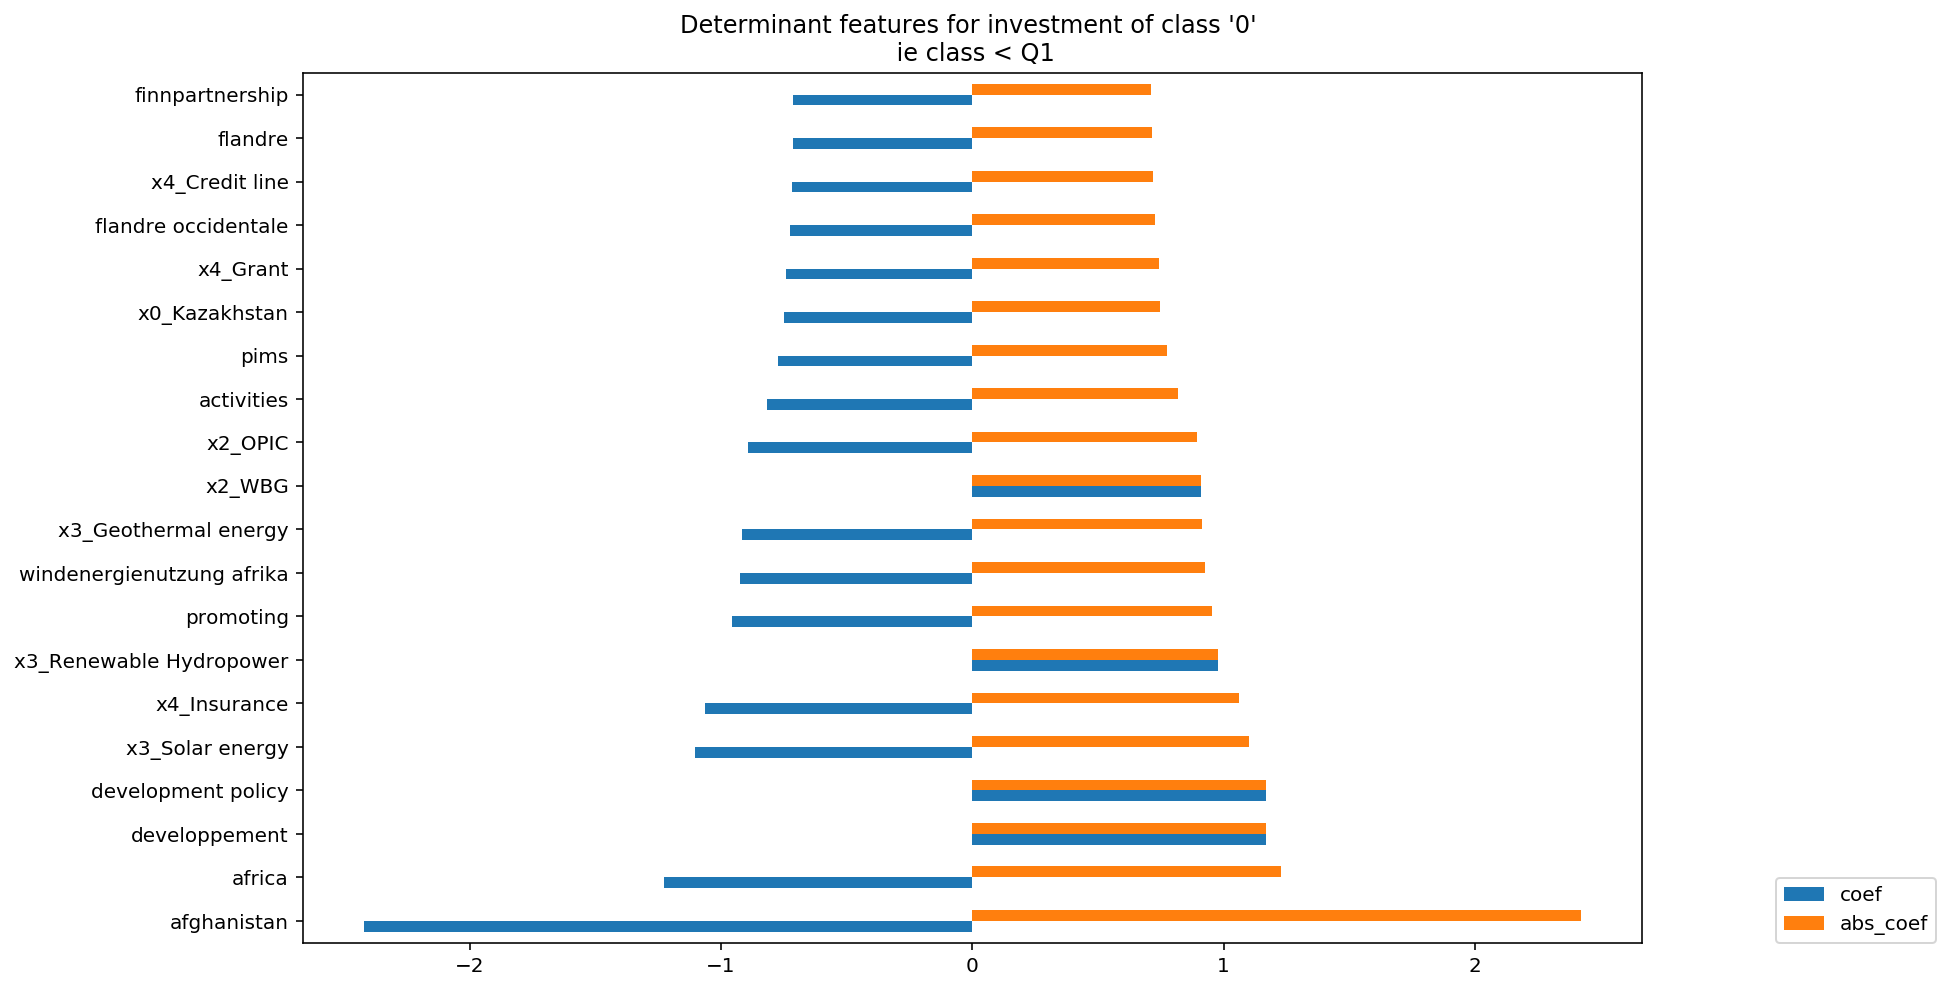

In [84]:
fi_0 = pd.DataFrame(list(zip(top_clf.Params[0].coef_[0],
                      abs(top_clf.Params[0].coef_[0]))),
             columns=['coef', 'abs_coef'], index = all_features).sort_values(
        by='abs_coef', ascending = False)[:20]
print(pd.DataFrame(fi_0))

fi_0.plot(kind = 'barh', figsize = (12, 8), title = "Determinant features for investment of class '0' \n ie class < Q1");
plt.legend(loc=[1.1,0])

                                                 coef  abs_coef
afghanistan                                 -2.567976  2.567976
africa                                      -1.441161  1.441161
x4_Other Official Flows (non Export Credit) -0.958173  0.958173
x3_Solar energy                             -0.944906  0.944906
x3_Geothermal energy                        -0.918136  0.918136
states                                       0.844387  0.844387
x2_EIB                                      -0.811070  0.811070
x4_Grant                                    -0.759100  0.759100
x4_Insurance                                -0.731184  0.731184
x4_Loan                                     -0.730147  0.730147
developpement                               -0.720134  0.720134
development policy                          -0.720134  0.720134
x4_Credit line                              -0.624723  0.624723
emission                                    -0.612333  0.612333
llc                                     

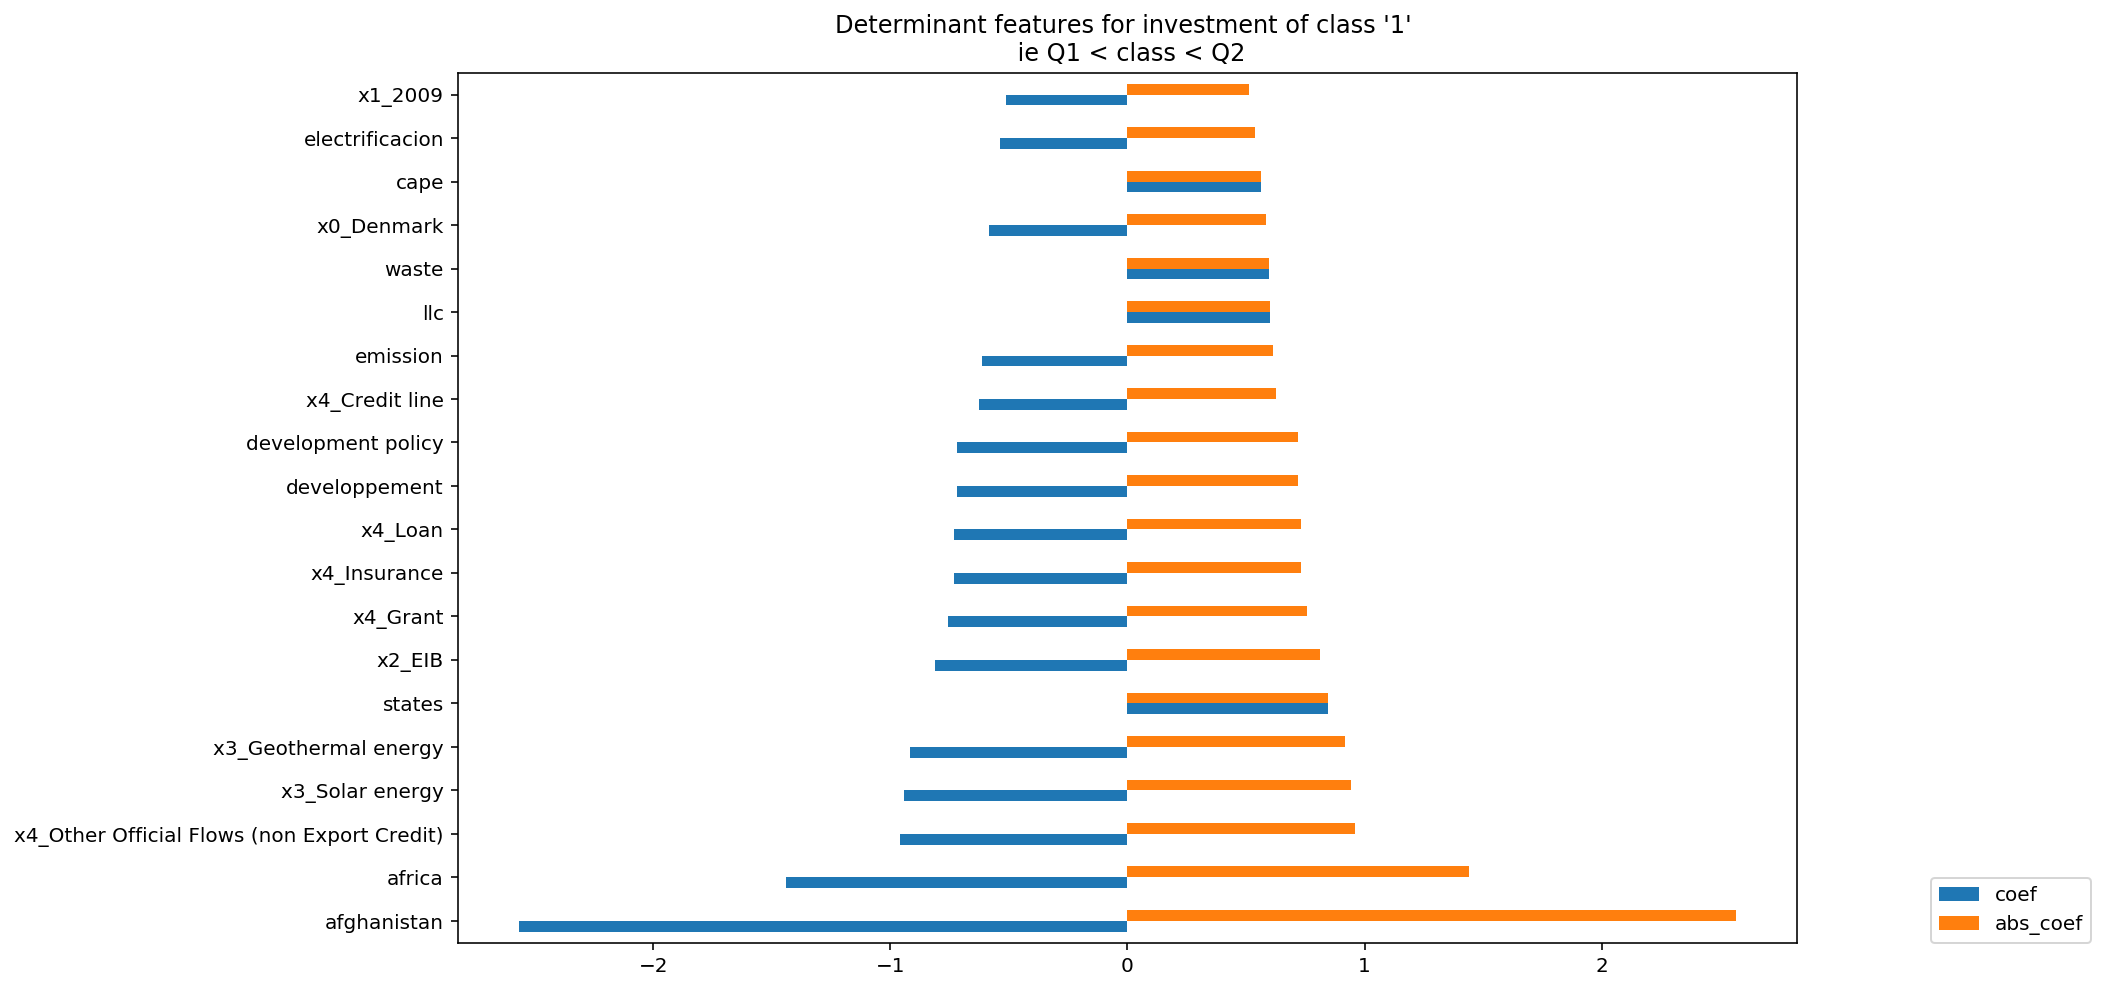

In [85]:
fi_1 = pd.DataFrame(list(zip(top_clf.Params[0].coef_[1],
                      abs(top_clf.Params[0].coef_[1]))),
             columns=['coef', 'abs_coef'], index = all_features).sort_values(
        by='abs_coef', ascending = False)[:20]
print(pd.DataFrame(fi_1))

fi_1.plot(kind = 'barh', figsize = (12, 8), title = "Determinant features for investment of class '1' \n ie Q1 < class < Q2");
plt.legend(loc=[1.1,0])

                             coef  abs_coef
x3_Renewable Hydropower -1.328715  1.328715
africa                  -1.215847  1.215847
finnpartnership          1.197531  1.197531
x3_Solar energy          1.123418  1.123418
afghanistan             -1.033187  1.033187
emission                 0.949006  0.949006
technical                0.843978  0.843978
electrificacion          0.831082  0.831082
protection               0.808533  0.808533
x2_NIB                   0.805136  0.805136
promoting                0.789927  0.789927
social                   0.786528  0.786528
x0_Belize               -0.779142  0.779142
activities               0.735315  0.735315
energi                   0.719810  0.719810
x0_Uruguay               0.703386  0.703386
x2_JBIC                 -0.688577  0.688577
x1_2011                 -0.681539  0.681539
x0_Eritrea              -0.675056  0.675056
flandre                  0.668433  0.668433


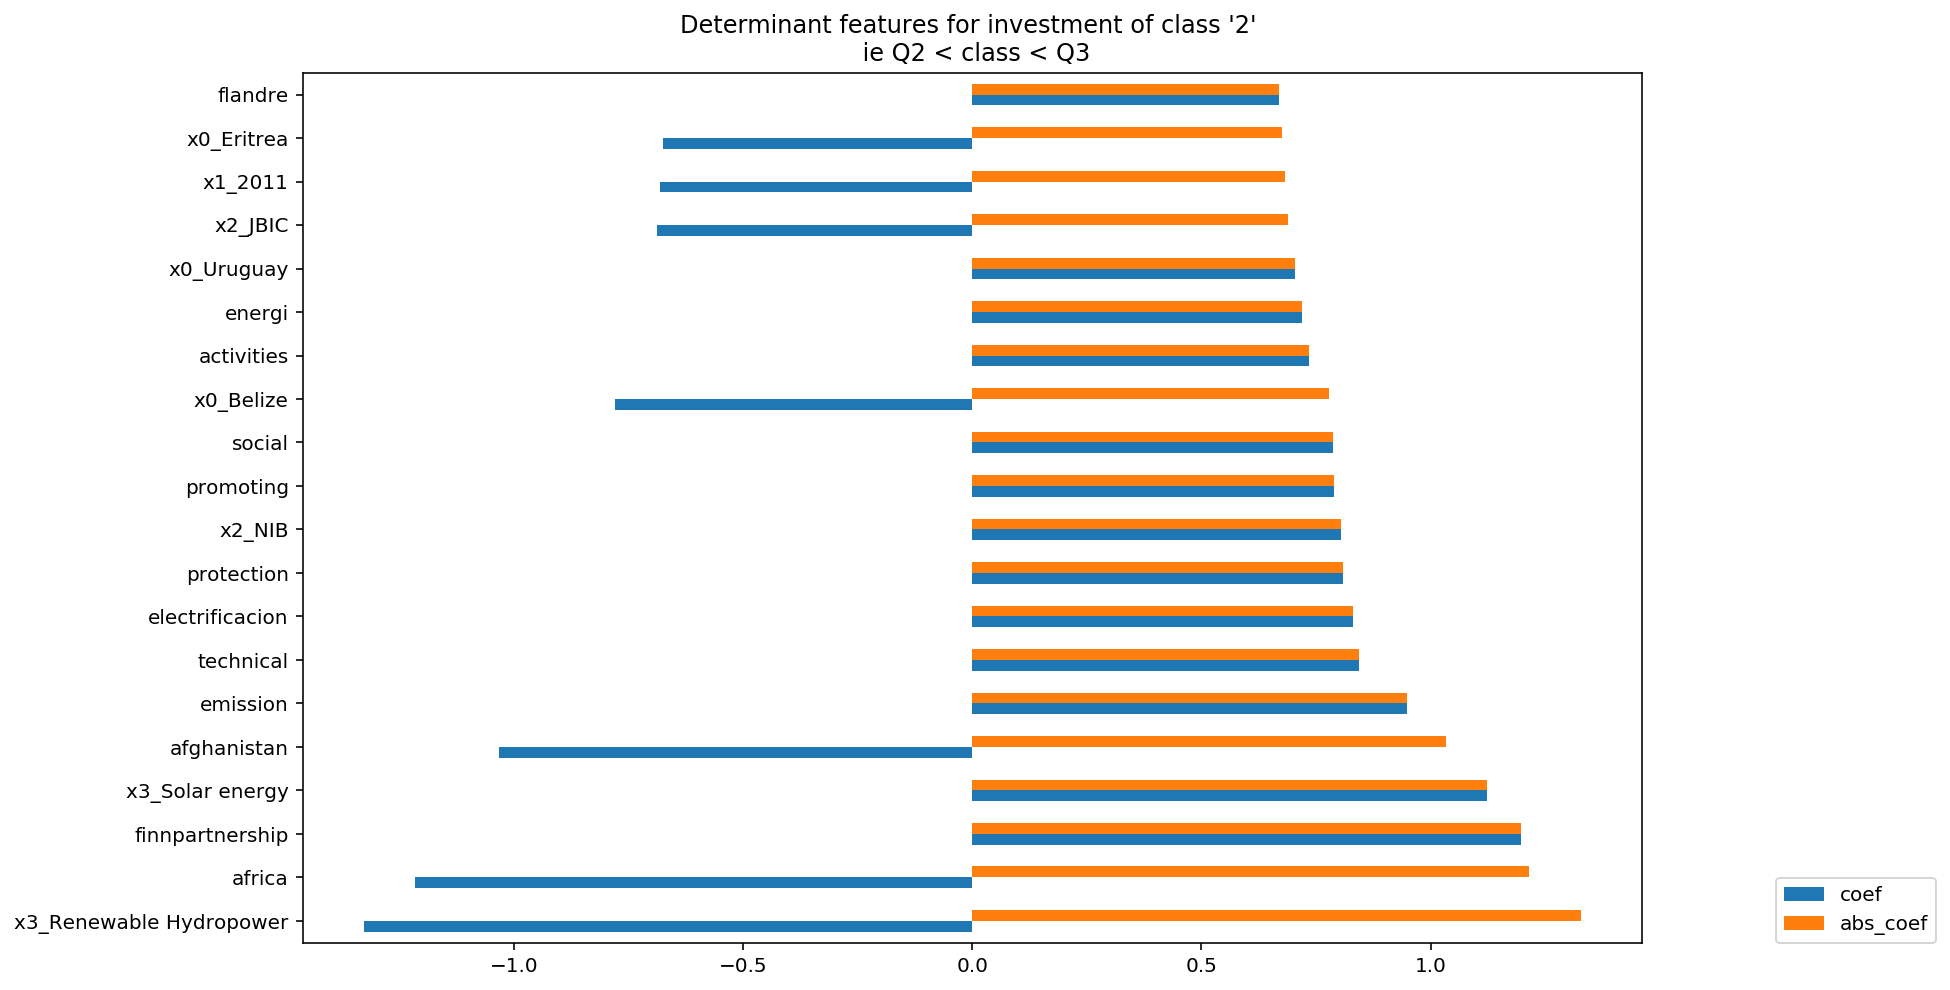

In [86]:
fi_2 = pd.DataFrame(list(zip(top_clf.Params[0].coef_[2],
                      abs(top_clf.Params[0].coef_[2]))),
             columns=['coef', 'abs_coef'], index = all_features).sort_values(
        by='abs_coef', ascending = False)[:20]
print(fi_2)
fi_2.plot(kind = 'barh', figsize = (12, 8), title = "Determinant features for investment of class '2' \n ie Q2 < class < Q3");
plt.legend(loc=[1.1,0])

                               coef  abs_coef
additional                -2.257494  2.257494
africa                     1.278832  1.278832
x3_Other renewable energy -1.261632  1.261632
afghanistan                1.165591  1.165591
x3_Solar energy           -0.974091  0.974091
x3_Renewable Hydropower   -0.819941  0.819941
x2_WBG                    -0.817035  0.817035
reverse                    0.798030  0.798030
x2_KFW                     0.791285  0.791285
x2_NIB                    -0.747110  0.747110
africa programme          -0.614933  0.614933
hydropower projects        0.612407  0.612407
antonio                   -0.605428  0.605428
apl                       -0.596885  0.596885
x0_Vanuatu                 0.568830  0.568830
pradesh                    0.563168  0.563168
activities                -0.556808  0.556808
x2_JBIC                    0.540798  0.540798
x0_Tuvalu                 -0.524036  0.524036
x4_Loan                   -0.516172  0.516172


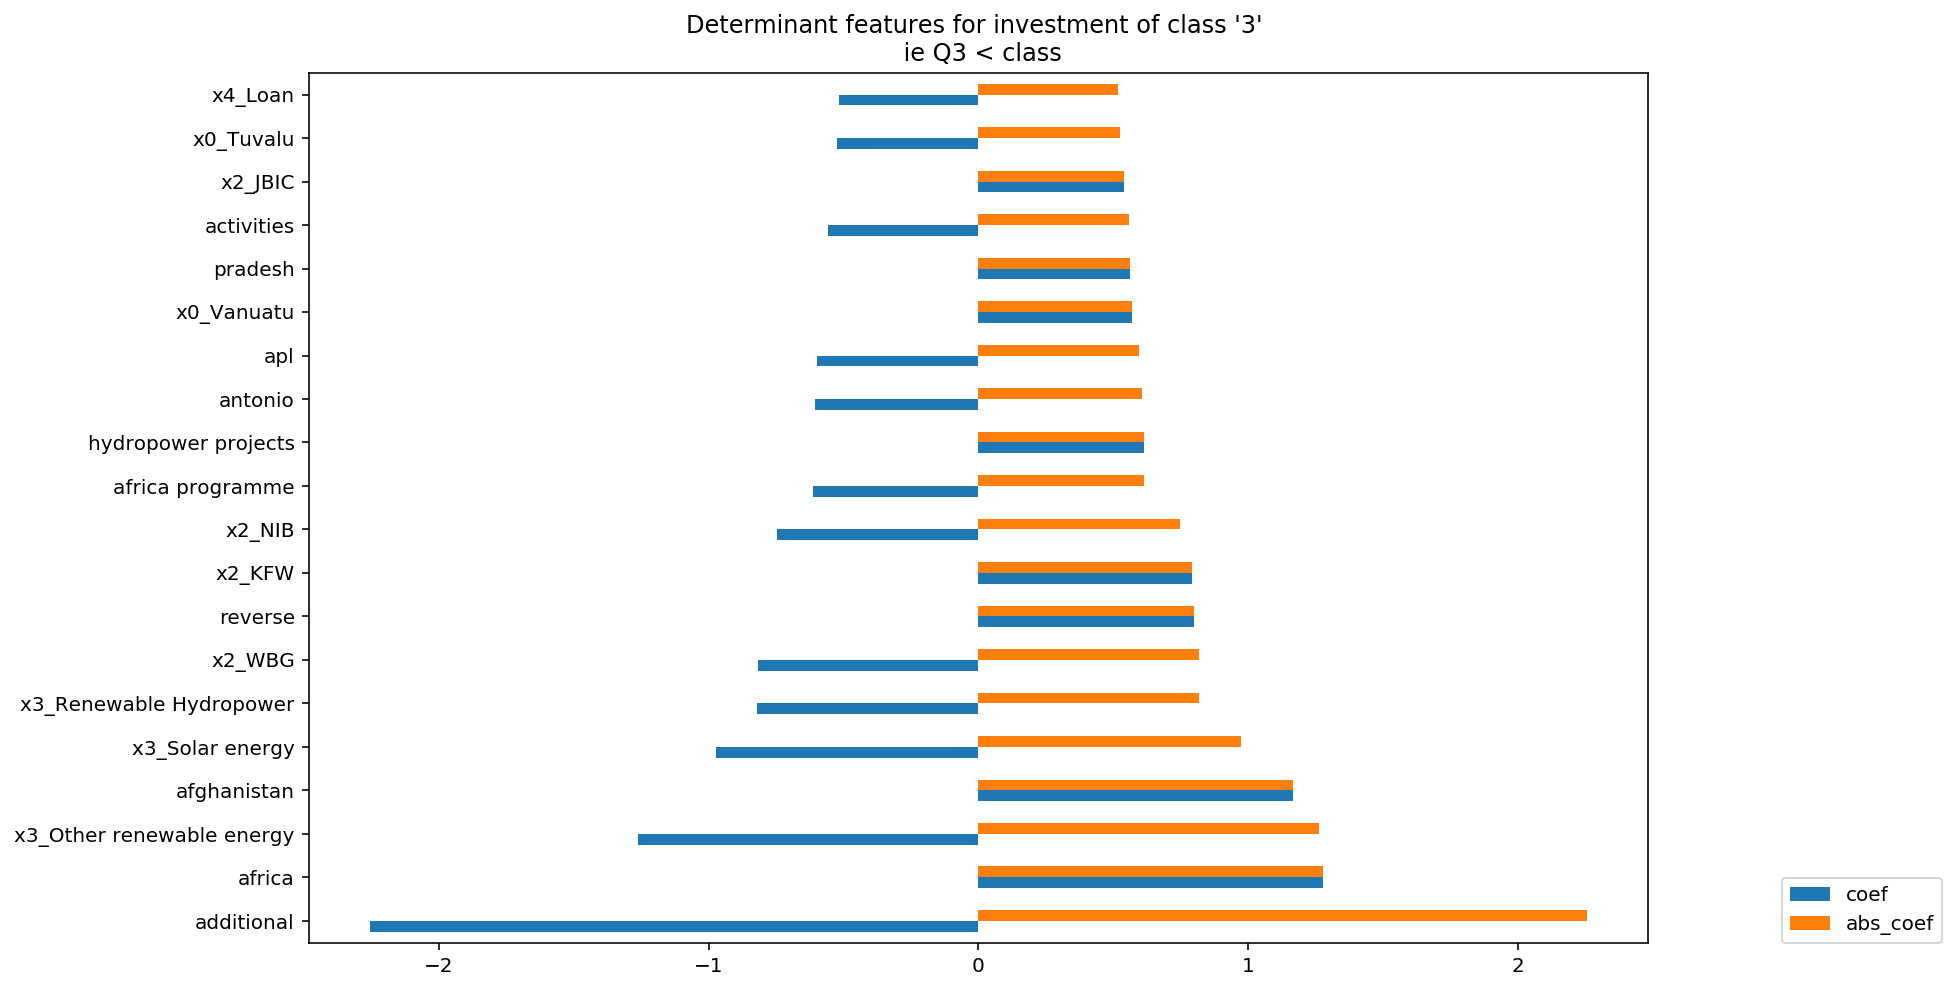

In [87]:
fi_3 = pd.DataFrame(list(zip(top_clf.Params[0].coef_[3],
                      abs(top_clf.Params[0].coef_[3]))),
             columns=['coef', 'abs_coef'], index = all_features).sort_values(
        by='abs_coef', ascending = False)[:20]
print(fi_3)
fi_3.plot(kind = 'barh', figsize = (12, 8), title = "Determinant features for investment of class '3' \n ie Q3 < class");
plt.legend(loc=[1.1,0])

In [216]:
top_clf.Params[1]

SVC(C=0.1668100537200059, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1e-05, kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [260]:
top_clf.Params[0].coef_.shape

(4, 792)

## Reflection on SVC's coefficients:  

Below I play with visualizing SVC's features. I don't carry through as I realize given SVC's 6 dimension, its coefficients are much intelligible to the model's resulting predictions than Logistic Regression's. 

Coefs' meaning: for 4 classes have 6 coefficients: 
coef[0,1], [0,2], [0,3] , [1, 2], [1, 3], [2,3] = All possible combos for dual coefs
1 coef per pair of classes
*^* NE to extact predicted labels by fitting the class 
Subset predictions twice on group from Q1 & Q2: 

In [276]:
top_clf.Params[1].decision_function(train_clX) #Tells me of the DB's location/position

array([[-0.27584901,  2.00057221,  3.27950436,  0.90553155],
       [ 0.83154887,  3.23118028,  2.21432151, -0.2508715 ],
       [ 0.84568586,  2.1938495 ,  3.23982221, -0.25188161],
       ...,
       [-0.27226361,  0.73737657,  2.25672018,  3.27607409],
       [ 3.25442224,  2.20399359,  0.81636996, -0.26046926],
       [ 3.22487562,  2.19937764,  0.93068198, -0.25580001]])

In [259]:
top_clf.Params[1].coef_.todense().shape

(6, 792)

SVM doesn't give probabilities, only tell you on which side of the decision boundary it is. J! a discriminative model, given features is it class A or B? 
Can trasnform this into a probability, by approximating decision boundary
*Coefs of linear paramaterize the line separating/ decision boundary
Obtain DB's location by matching 
At intercept all ==0 -> equation of coefs 
If equation > < o --> determines to wc/ class data bE 

Depending on coef: how feature places itself around the DB

                               coef  abs_coef
development policy         1.262792  1.262792
developpement              1.262792  1.262792
x2_WBG                     1.201209  1.201209
windenergienutzung afrika -1.090777  1.090777
small hydropower           1.021683  1.021683
pims                      -0.950001  0.950001
increased                  0.859516  0.859516
x2_OPIC                   -0.851426  0.851426
x0_Senegal                 0.841565  0.841565
x0_Panama                  0.830767  0.830767
states                    -0.819019  0.819019
stoves                     0.794832  0.794832
cape                      -0.782387  0.782387
flandre occidentale       -0.775573  0.775573
living conditions          0.774048  0.774048
x3_Renewable Hydropower    0.716702  0.716702
llc                       -0.704233  0.704233
africa business           -0.695662  0.695662
mercosur countries         0.688247  0.688247
rural electrification      0.683022  0.683022


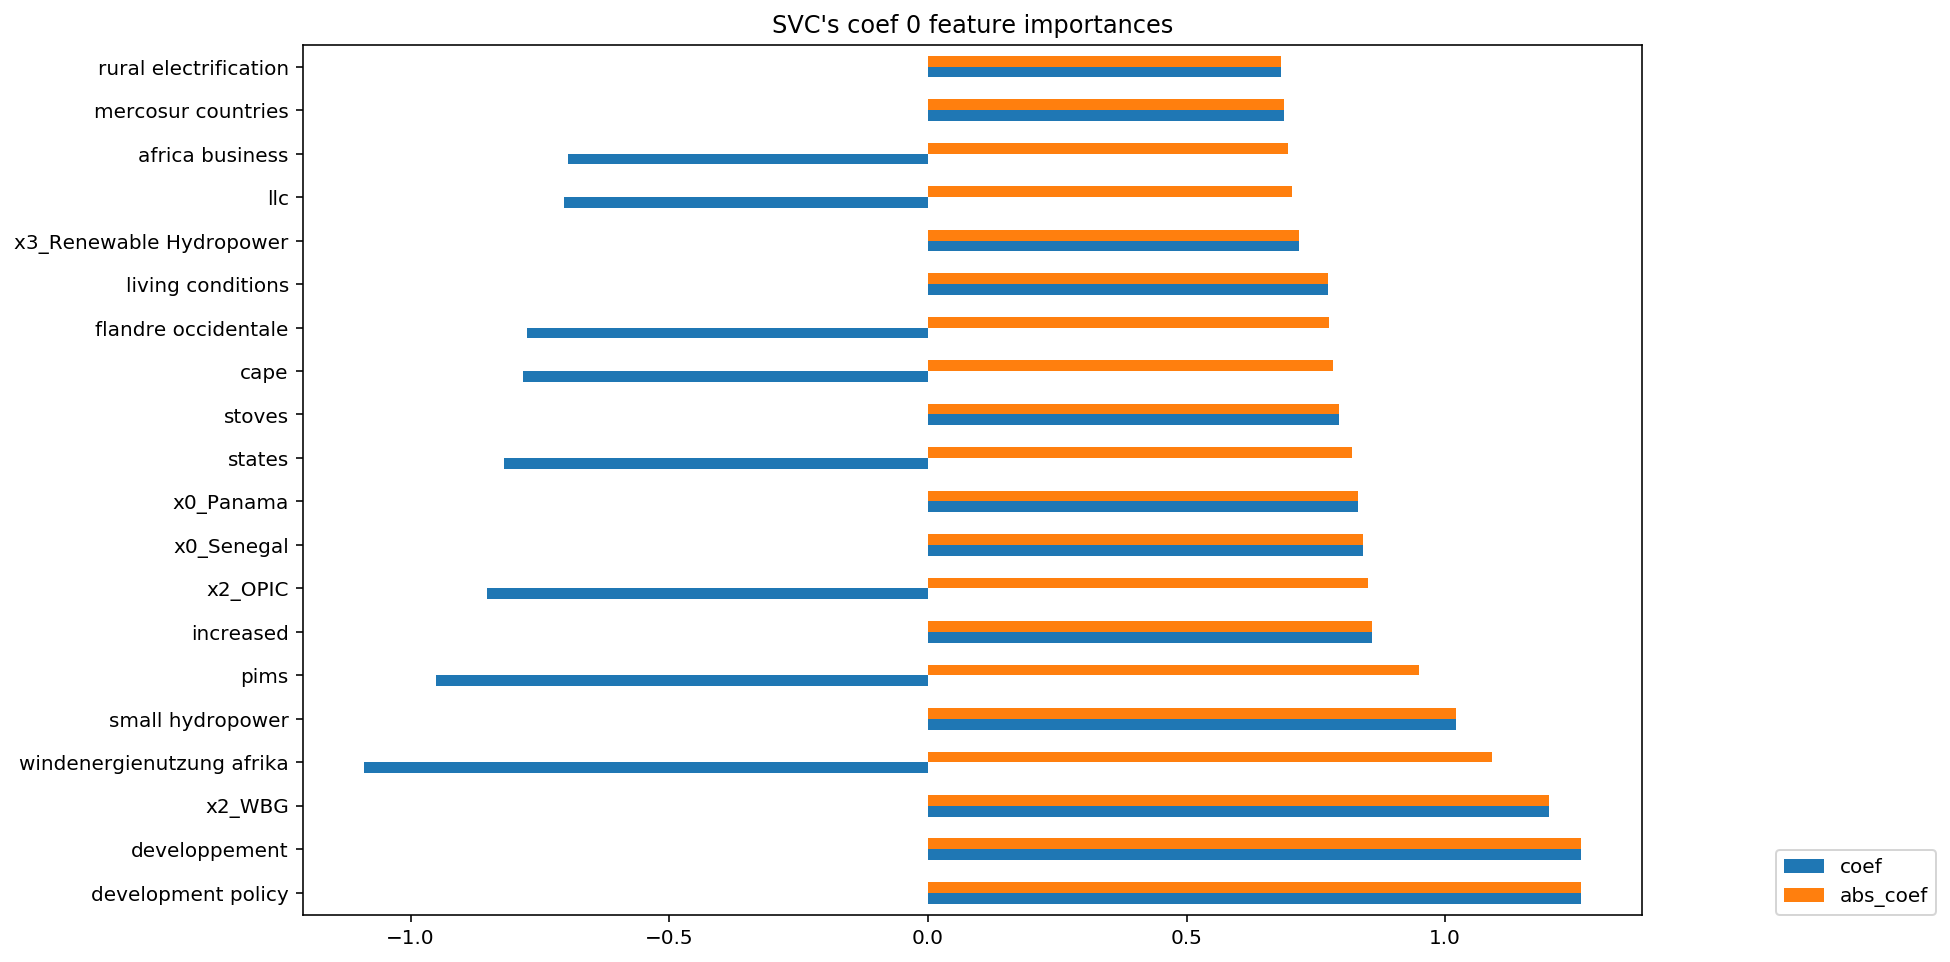

In [202]:
svc_coef0 = pd.DataFrame(top_clf.Params[1].coef_[0].todense())
svc_coef0 = svc_coef0.T
svc_coef0.rename(columns = {0: 'coef'}, inplace=True)
svc_coef0.index = all_features
svc_coef0['abs_coef'] = abs(svc_coef0.coef)

svcfi_0 = svc_coef0.sort_values(
        by='abs_coef', ascending = False)[:20]
print(pd.DataFrame(svcfi_0))

svcfi_0.plot(kind = 'barh', figsize = (12, 8), title = "SVC's coef 0 feature importances \n Class 0 vs 1");
plt.legend(loc=[1.1,0]);

                             coef  abs_coef
x3_Renewable Hydropower  1.496726  1.496726
finnpartnership         -1.420770  1.420770
flandre occidentale     -1.281132  1.281132
x2_WBG                   1.181537  1.181537
x0_Niger                -1.167670  1.167670
electrificacion         -1.163677  1.163677
flandre                 -1.152148  1.152148
additional               1.079488  1.079488
emission                -1.069376  1.069376
promoting               -1.018176  1.018176
x0_Kazakhstan           -0.973915  0.973915
geothermal development  -0.970191  0.970191
proteccion supply       -0.959100  0.959100
community               -0.954282  0.954282
technical               -0.929000  0.929000
x3_Geothermal energy    -0.889401  0.889401
x2_OPIC                 -0.864884  0.864884
development policy       0.823144  0.823144
developpement            0.823144  0.823144
monitoring              -0.814779  0.814779


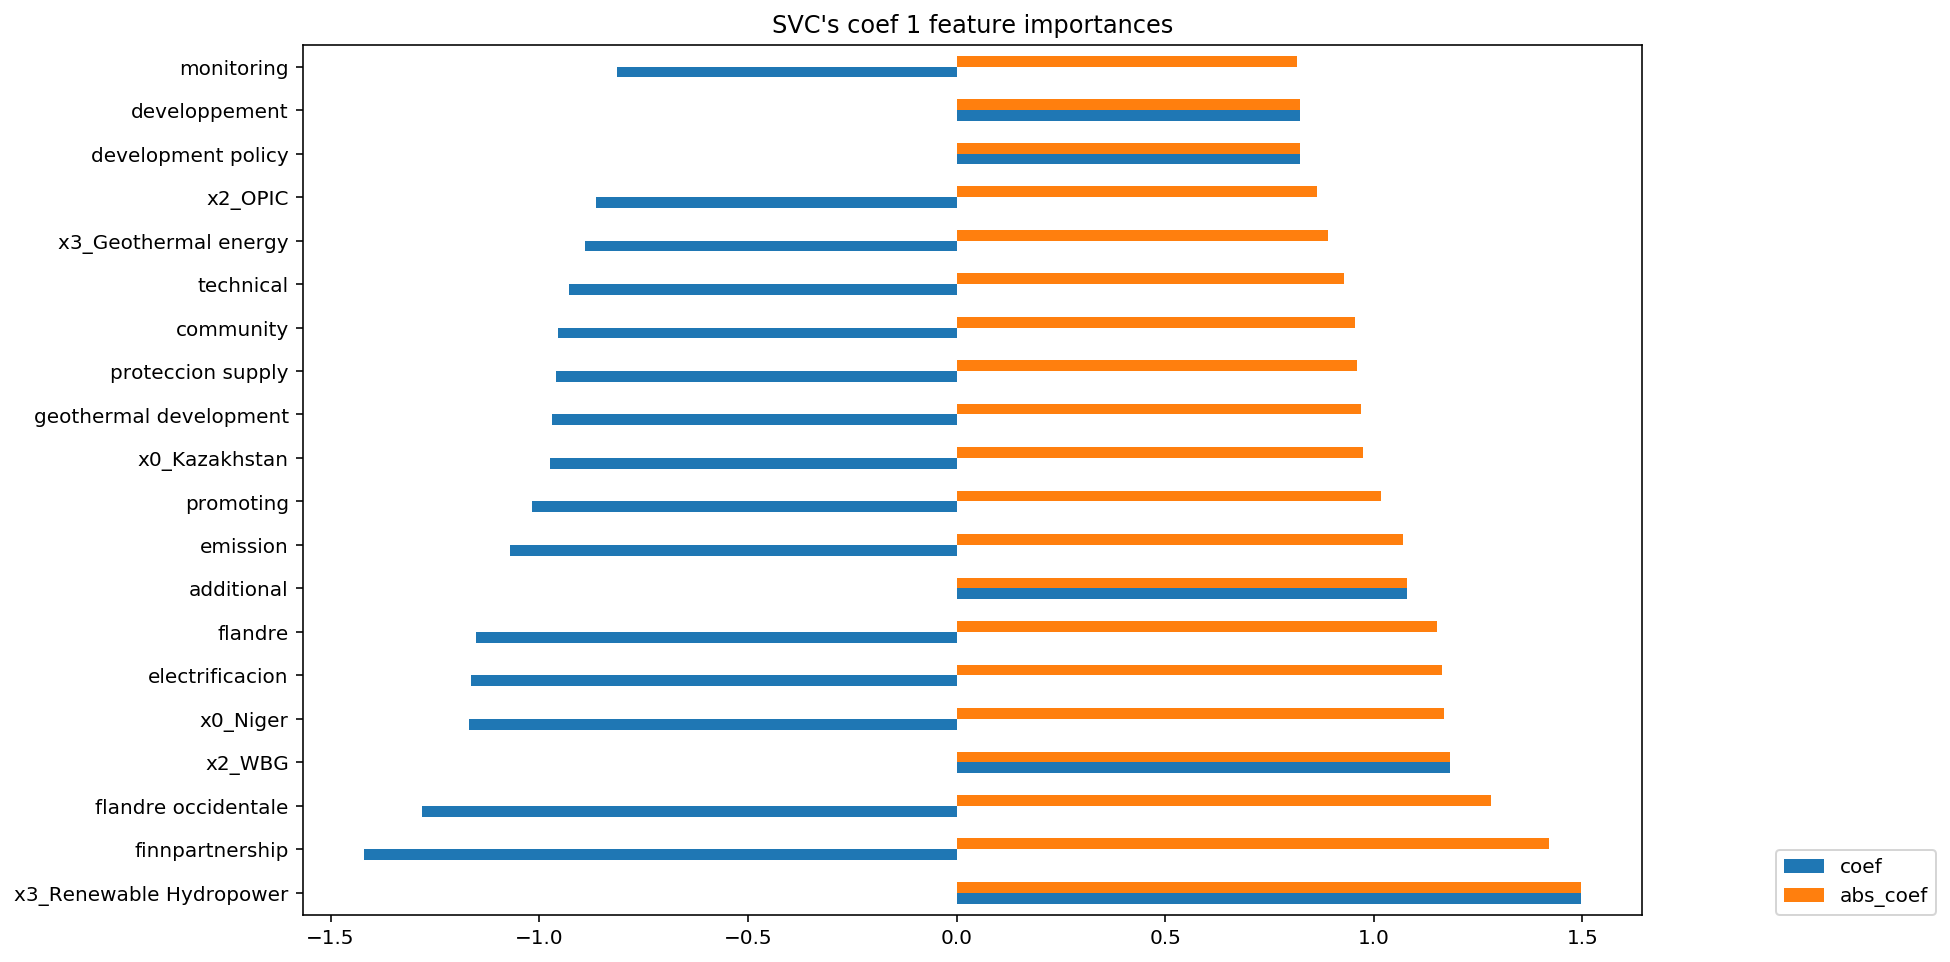

In [204]:
svc_coef1 = pd.DataFrame(top_clf.Params[1].coef_[1].todense())
svc_coef1 = svc_coef1.T
svc_coef1.rename(columns = {0: 'coef'}, inplace=True)
svc_coef1.index = all_features
svc_coef1['abs_coef'] = abs(svc_coef1.coef)

svcfi_1 = svc_coef1.sort_values(
        by='abs_coef', ascending = False)[:20]
print(pd.DataFrame(svcfi_1))

svcfi_1.plot(kind = 'barh', figsize = (12, 8), title = "SVC's coef 1 feature importances");
plt.legend(loc=[1.1,0]);

                               coef  abs_coef
development policy         1.262792  1.262792
developpement              1.262792  1.262792
x2_WBG                     1.201209  1.201209
windenergienutzung afrika -1.090777  1.090777
small hydropower           1.021683  1.021683
pims                      -0.950001  0.950001
increased                  0.859516  0.859516
x2_OPIC                   -0.851426  0.851426
x0_Senegal                 0.841565  0.841565
x0_Panama                  0.830767  0.830767
states                    -0.819019  0.819019
stoves                     0.794832  0.794832
cape                      -0.782387  0.782387
flandre occidentale       -0.775573  0.775573
living conditions          0.774048  0.774048
x3_Renewable Hydropower    0.716702  0.716702
llc                       -0.704233  0.704233
africa business           -0.695662  0.695662
mercosur countries         0.688247  0.688247
rural electrification      0.683022  0.683022


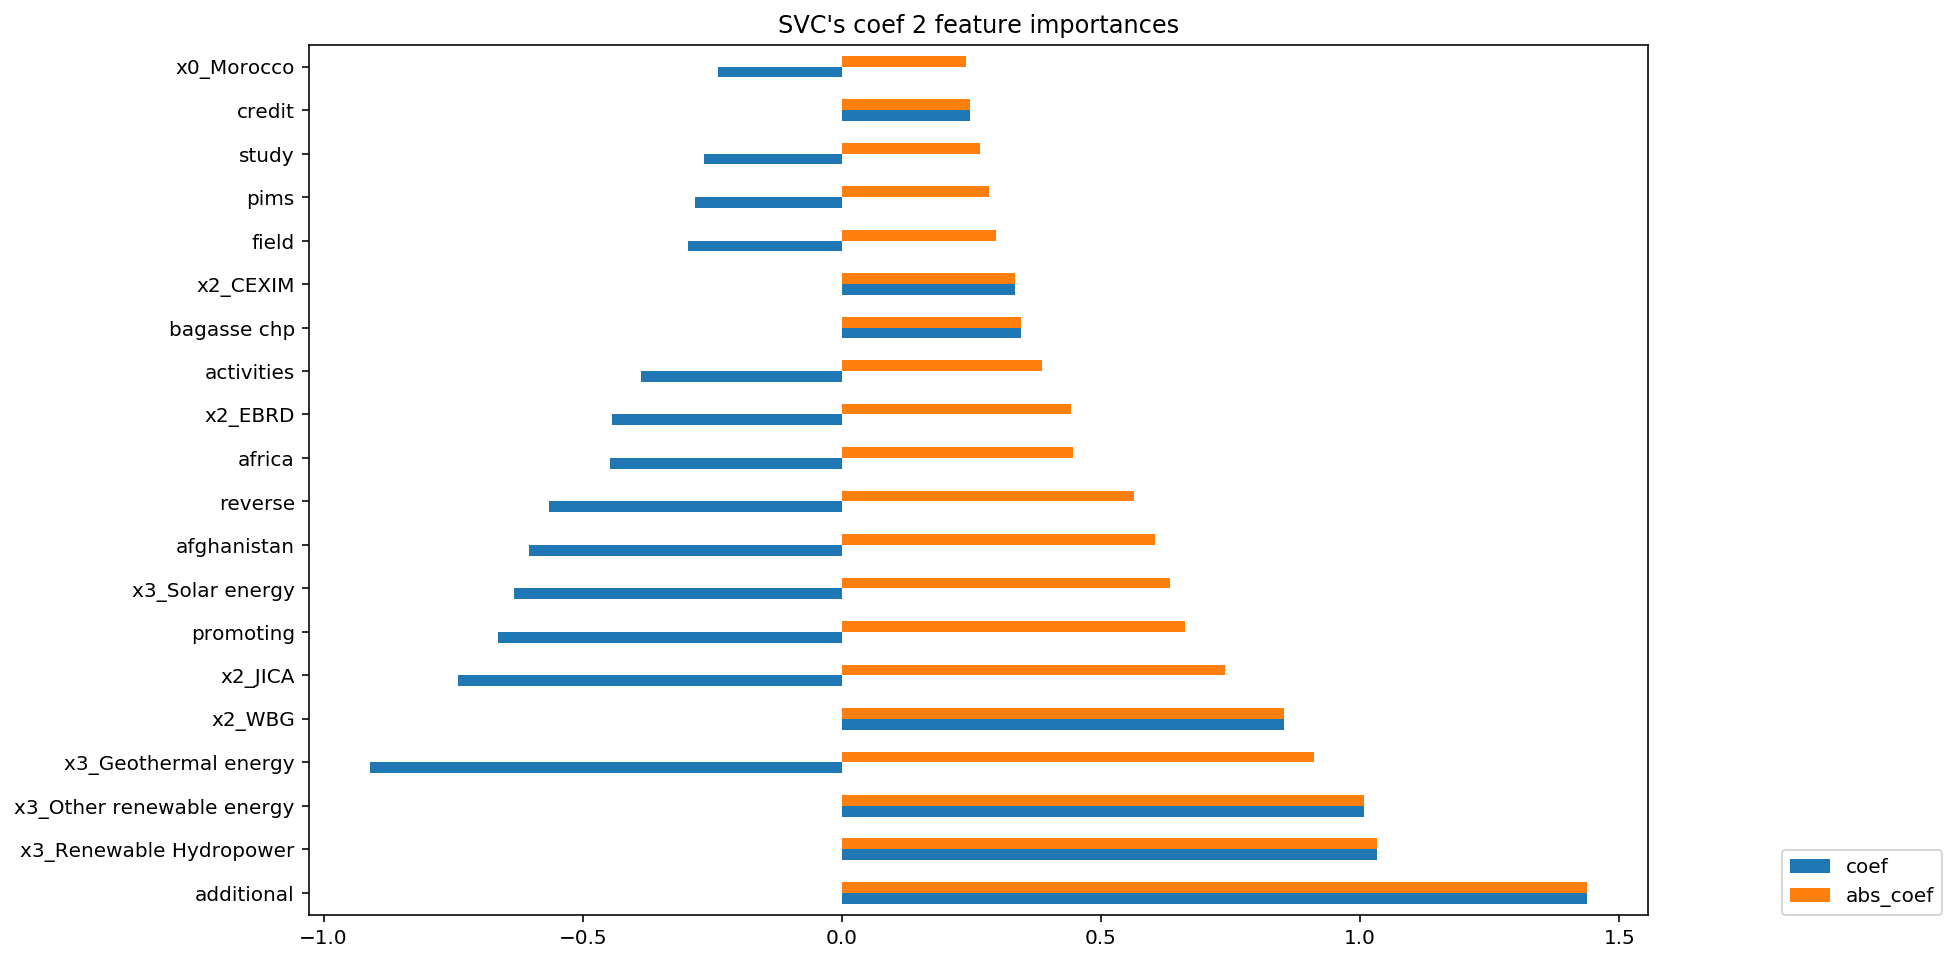

In [205]:
svc_coef2 = pd.DataFrame(top_clf.Params[1].coef_[2].todense())
svc_coef2 = svc_coef2.T
svc_coef2.rename(columns = {0: 'coef'}, inplace=True)
svc_coef2.index = all_features
svc_coef2['abs_coef'] = abs(svc_coef2.coef)

svcfi_2 = svc_coef2.sort_values(
        by='abs_coef', ascending = False)[:20]
print(pd.DataFrame(svcfi_0))

svcfi_2.plot(kind = 'barh', figsize = (12, 8), title = "SVC's coef 2 feature importances");
plt.legend(loc=[1.1,0]);

                               coef  abs_coef
development policy         1.262792  1.262792
developpement              1.262792  1.262792
x2_WBG                     1.201209  1.201209
windenergienutzung afrika -1.090777  1.090777
small hydropower           1.021683  1.021683
pims                      -0.950001  0.950001
increased                  0.859516  0.859516
x2_OPIC                   -0.851426  0.851426
x0_Senegal                 0.841565  0.841565
x0_Panama                  0.830767  0.830767
states                    -0.819019  0.819019
stoves                     0.794832  0.794832
cape                      -0.782387  0.782387
flandre occidentale       -0.775573  0.775573
living conditions          0.774048  0.774048
x3_Renewable Hydropower    0.716702  0.716702
llc                       -0.704233  0.704233
africa business           -0.695662  0.695662
mercosur countries         0.688247  0.688247
rural electrification      0.683022  0.683022


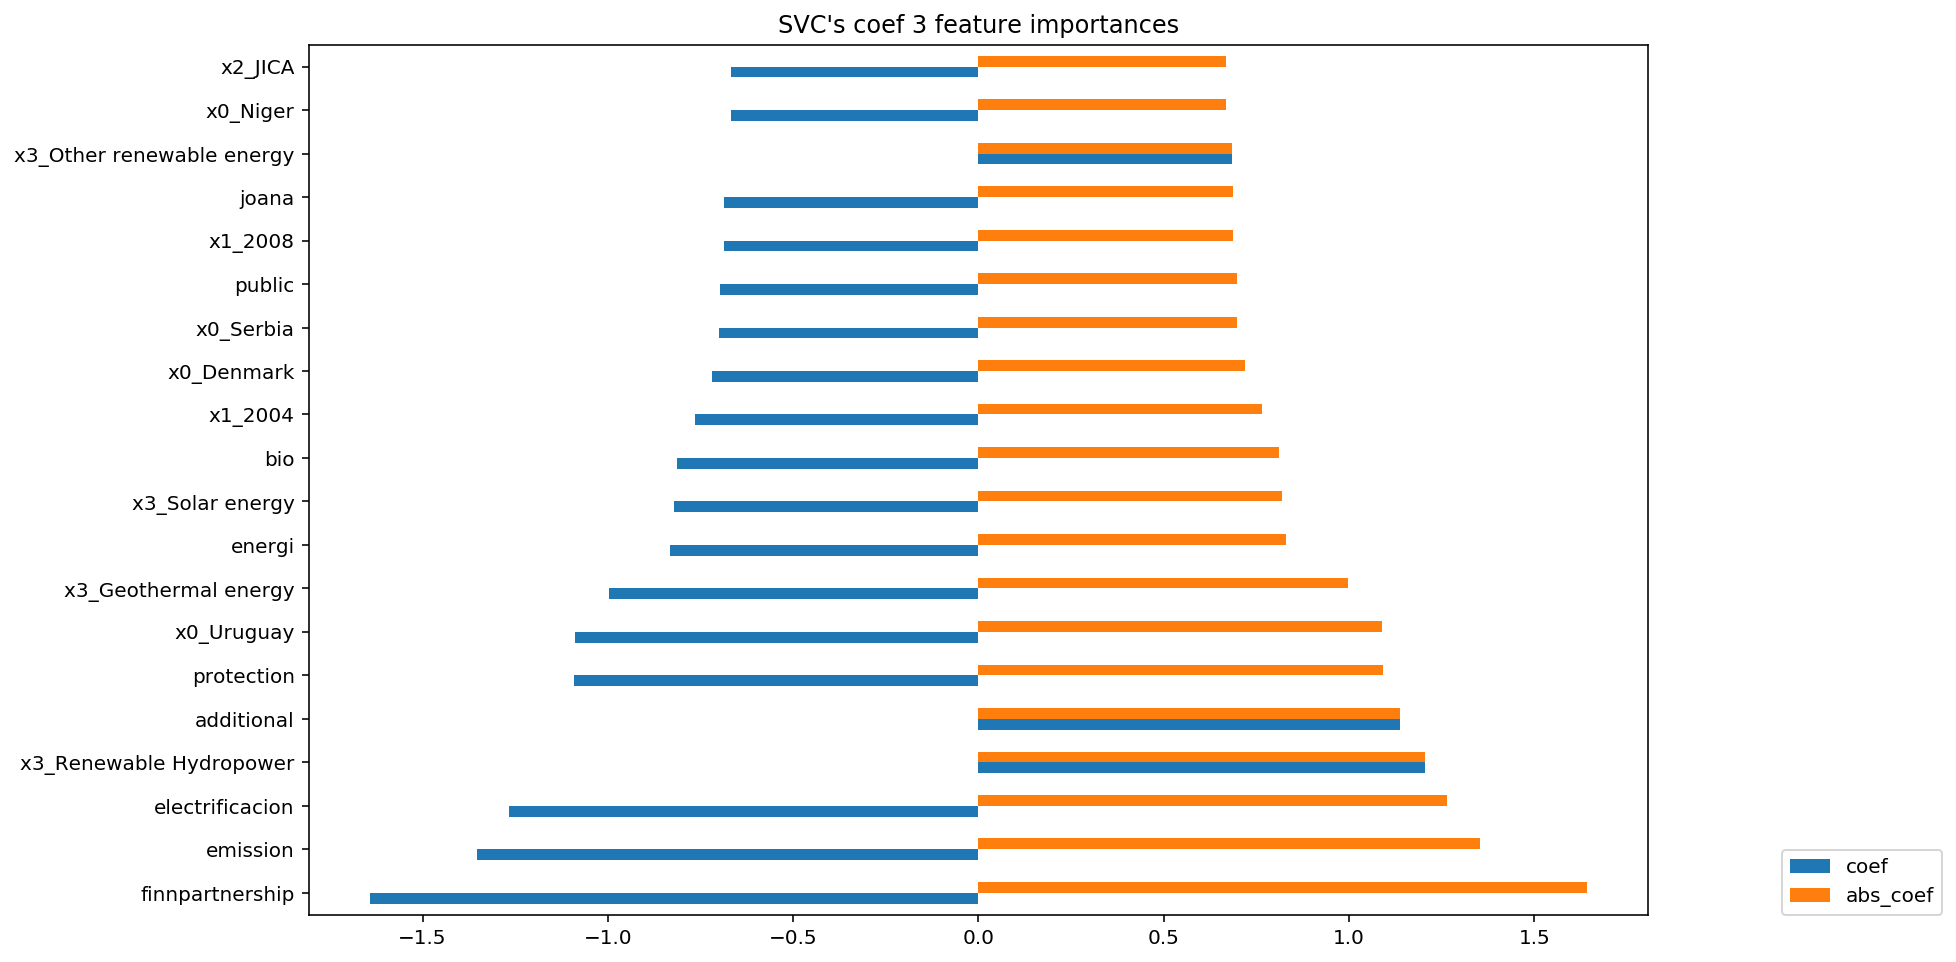

In [206]:
svc_coef3 = pd.DataFrame(top_clf.Params[1].coef_[3].todense())
svc_coef3 = svc_coef3.T
svc_coef3.rename(columns = {0: 'coef'}, inplace=True)
svc_coef3.index = all_features
svc_coef3['abs_coef'] = abs(svc_coef3.coef)

svcfi_3 = svc_coef3.sort_values(
        by='abs_coef', ascending = False)[:20]
print(pd.DataFrame(svcfi_0))

svcfi_3.plot(kind = 'barh', figsize = (12, 8), title = "SVC's coef 3 feature importances");
plt.legend(loc=[1.1,0]);

                               coef  abs_coef
development policy         1.262792  1.262792
developpement              1.262792  1.262792
x2_WBG                     1.201209  1.201209
windenergienutzung afrika -1.090777  1.090777
small hydropower           1.021683  1.021683
pims                      -0.950001  0.950001
increased                  0.859516  0.859516
x2_OPIC                   -0.851426  0.851426
x0_Senegal                 0.841565  0.841565
x0_Panama                  0.830767  0.830767
states                    -0.819019  0.819019
stoves                     0.794832  0.794832
cape                      -0.782387  0.782387
flandre occidentale       -0.775573  0.775573
living conditions          0.774048  0.774048
x3_Renewable Hydropower    0.716702  0.716702
llc                       -0.704233  0.704233
africa business           -0.695662  0.695662
mercosur countries         0.688247  0.688247
rural electrification      0.683022  0.683022


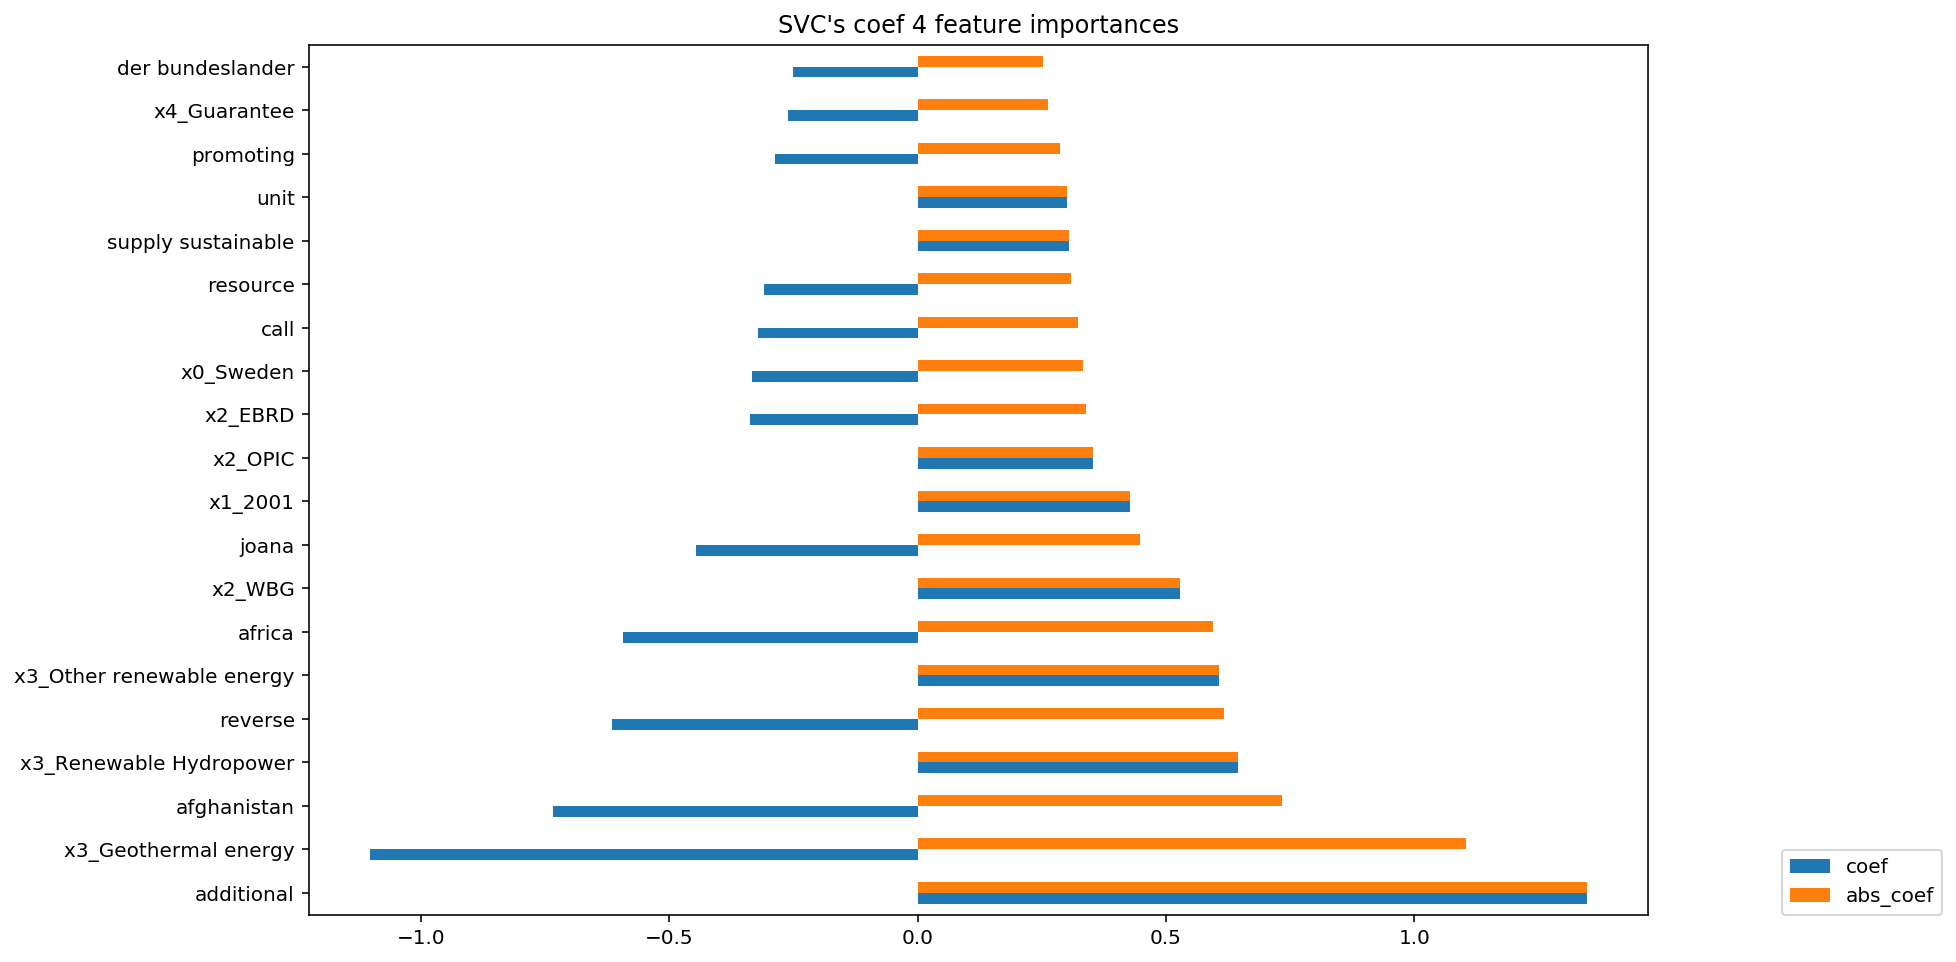

In [207]:
svc_coef4 = pd.DataFrame(top_clf.Params[1].coef_[4].todense())
svc_coef4 = svc_coef4.T
svc_coef4.rename(columns = {0: 'coef'}, inplace=True)
svc_coef4.index = all_features
svc_coef4['abs_coef'] = abs(svc_coef4.coef)

svcfi_4 = svc_coef4.sort_values(
        by='abs_coef', ascending = False)[:20]
print(pd.DataFrame(svcfi_0))

svcfi_4.plot(kind = 'barh', figsize = (12, 8), title = "SVC's coef 4 feature importances");
plt.legend(loc=[1.1,0]);

                               coef  abs_coef
development policy         1.262792  1.262792
developpement              1.262792  1.262792
x2_WBG                     1.201209  1.201209
windenergienutzung afrika -1.090777  1.090777
small hydropower           1.021683  1.021683
pims                      -0.950001  0.950001
increased                  0.859516  0.859516
x2_OPIC                   -0.851426  0.851426
x0_Senegal                 0.841565  0.841565
x0_Panama                  0.830767  0.830767
states                    -0.819019  0.819019
stoves                     0.794832  0.794832
cape                      -0.782387  0.782387
flandre occidentale       -0.775573  0.775573
living conditions          0.774048  0.774048
x3_Renewable Hydropower    0.716702  0.716702
llc                       -0.704233  0.704233
africa business           -0.695662  0.695662
mercosur countries         0.688247  0.688247
rural electrification      0.683022  0.683022


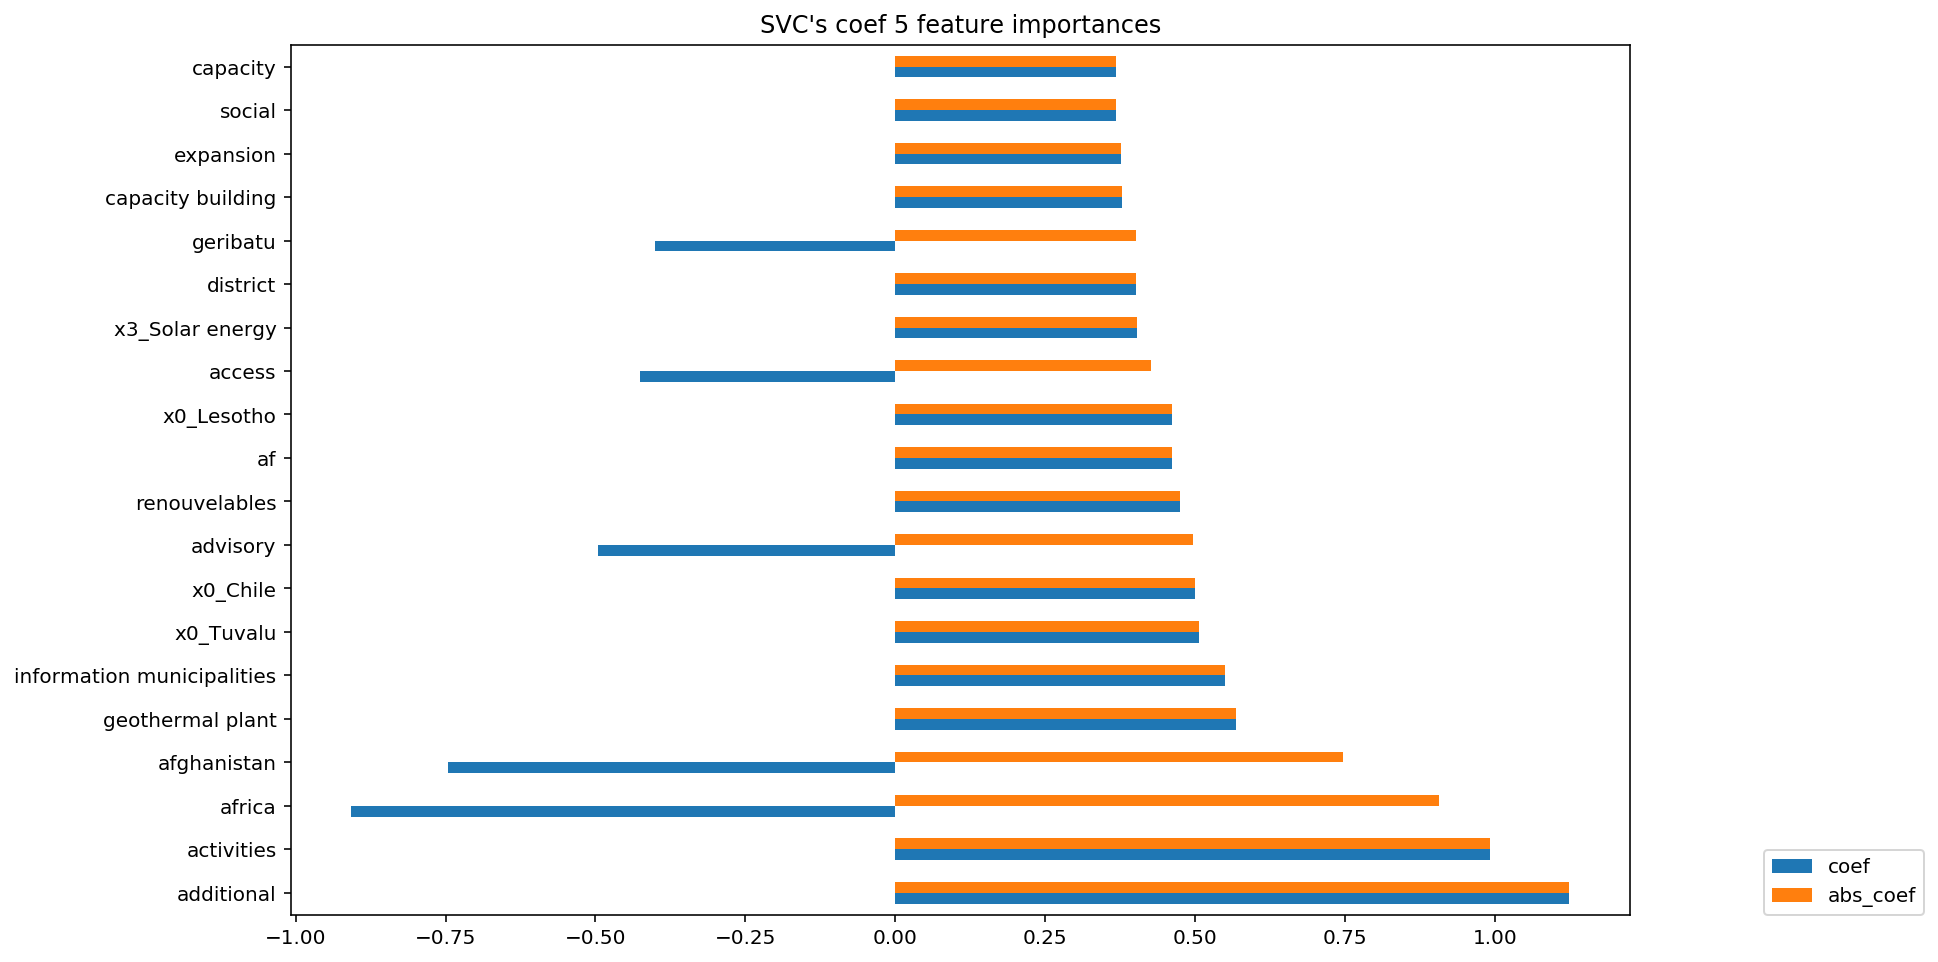

In [208]:
svc_coef5 = pd.DataFrame(top_clf.Params[1].coef_[5].todense())
svc_coef5 = svc_coef5.T
svc_coef5.rename(columns = {0: 'coef'}, inplace=True)
svc_coef5.index = all_features
svc_coef5['abs_coef'] = abs(svc_coef5.coef)

svcfi_5 = svc_coef5.sort_values(
        by='abs_coef', ascending = False)[:20]
print(pd.DataFrame(svcfi_0))

svcfi_5.plot(kind = 'barh', figsize = (12, 8), title = "SVC's coef 5 feature importances");
plt.legend(loc=[1.1,0]);

## Plotting revelatory curves: ROC & Precision-Recall 

Below I plot top 3 classifiers' revelatory curves to visualize how their performance over different classifying threshold levels. Cf README for analysis

In [140]:
top_clf.Params[0].predict_proba(test_clX)

array([[0.42600306, 0.39181716, 0.12259674, 0.05958303],
       [0.25514059, 0.39163785, 0.30115473, 0.05206684],
       [0.44887369, 0.28082891, 0.24805402, 0.02224338],
       ...,
       [0.33518985, 0.33853741, 0.29941881, 0.02685393],
       [0.38713652, 0.4291694 , 0.16902194, 0.01467213],
       [0.53248172, 0.27141508, 0.18388459, 0.01221861]])

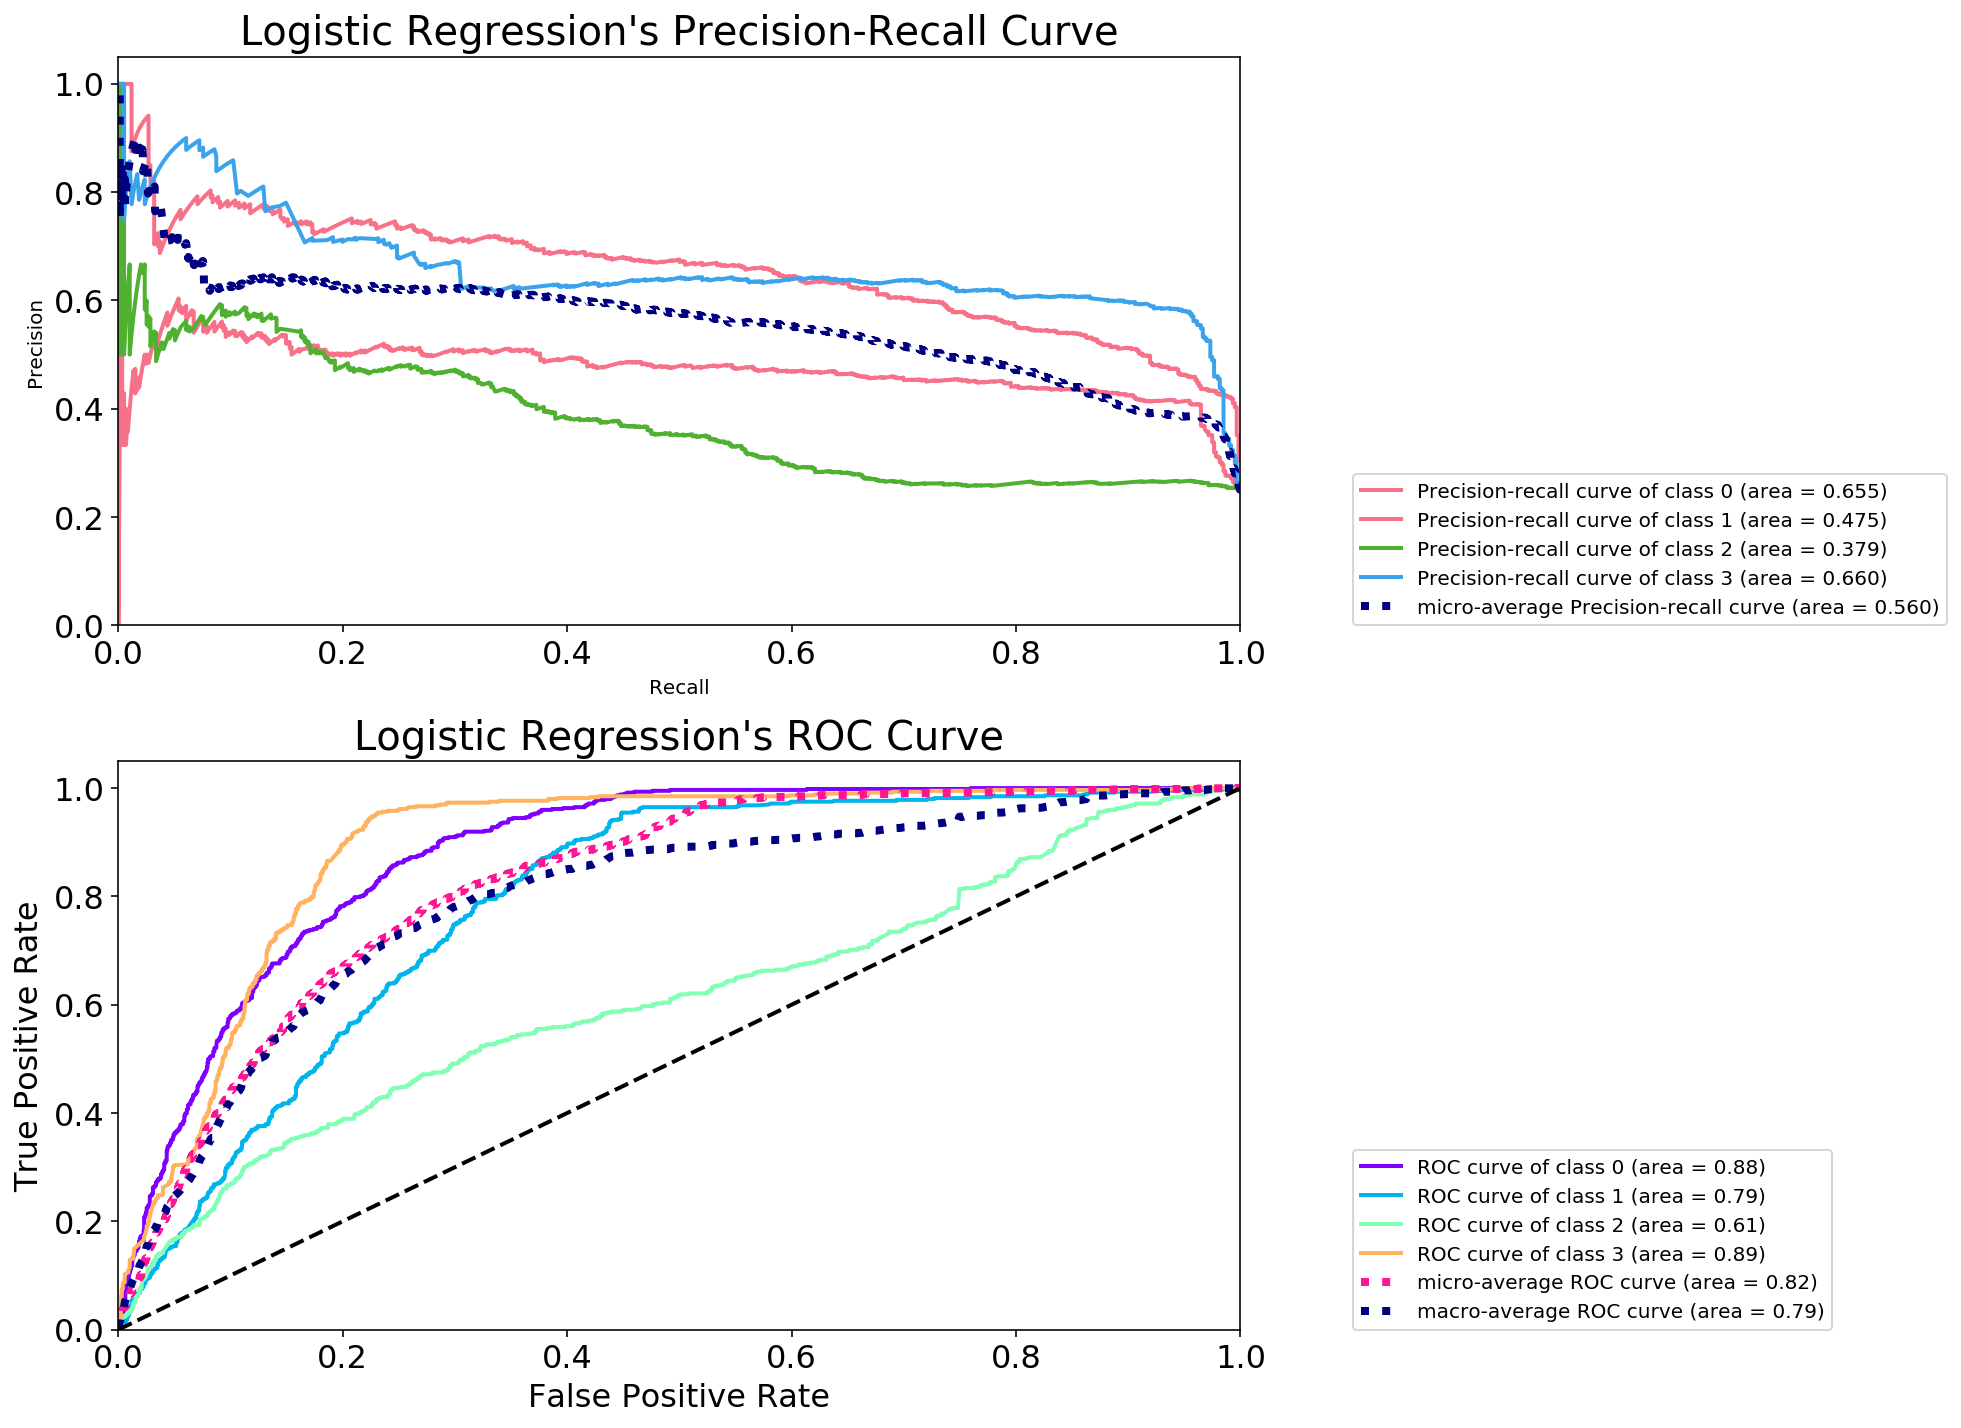

In [141]:
fig, ax = plt.subplots(2, 1, figsize = (14, 10))

skplt.metrics.plot_precision_recall(yc_test, top_clf.Params[0].predict_proba(test_clX), 
                       plot_micro=True, title = "Logistic Regression's Precision-Recall Curve",
                       title_fontsize=20, text_fontsize=16, cmap=cmap, ax=ax[0])
ax[0].legend(loc=[1.1, 0])


skplt.metrics.plot_roc(yc_test, top_clf.Params[0].predict_proba(test_clX), plot_micro=True, plot_macro=True,
                       title = "Logistic Regression's ROC Curve",
    title_fontsize=20, text_fontsize=16, cmap= 'rainbow', ax = ax[1])

ax[1].legend(loc=[1.1,0])

#fig.suptitle("Logistic Regression's alternative scoring: \n", fontsize = 16)

plt.tight_layout()
plt.show()

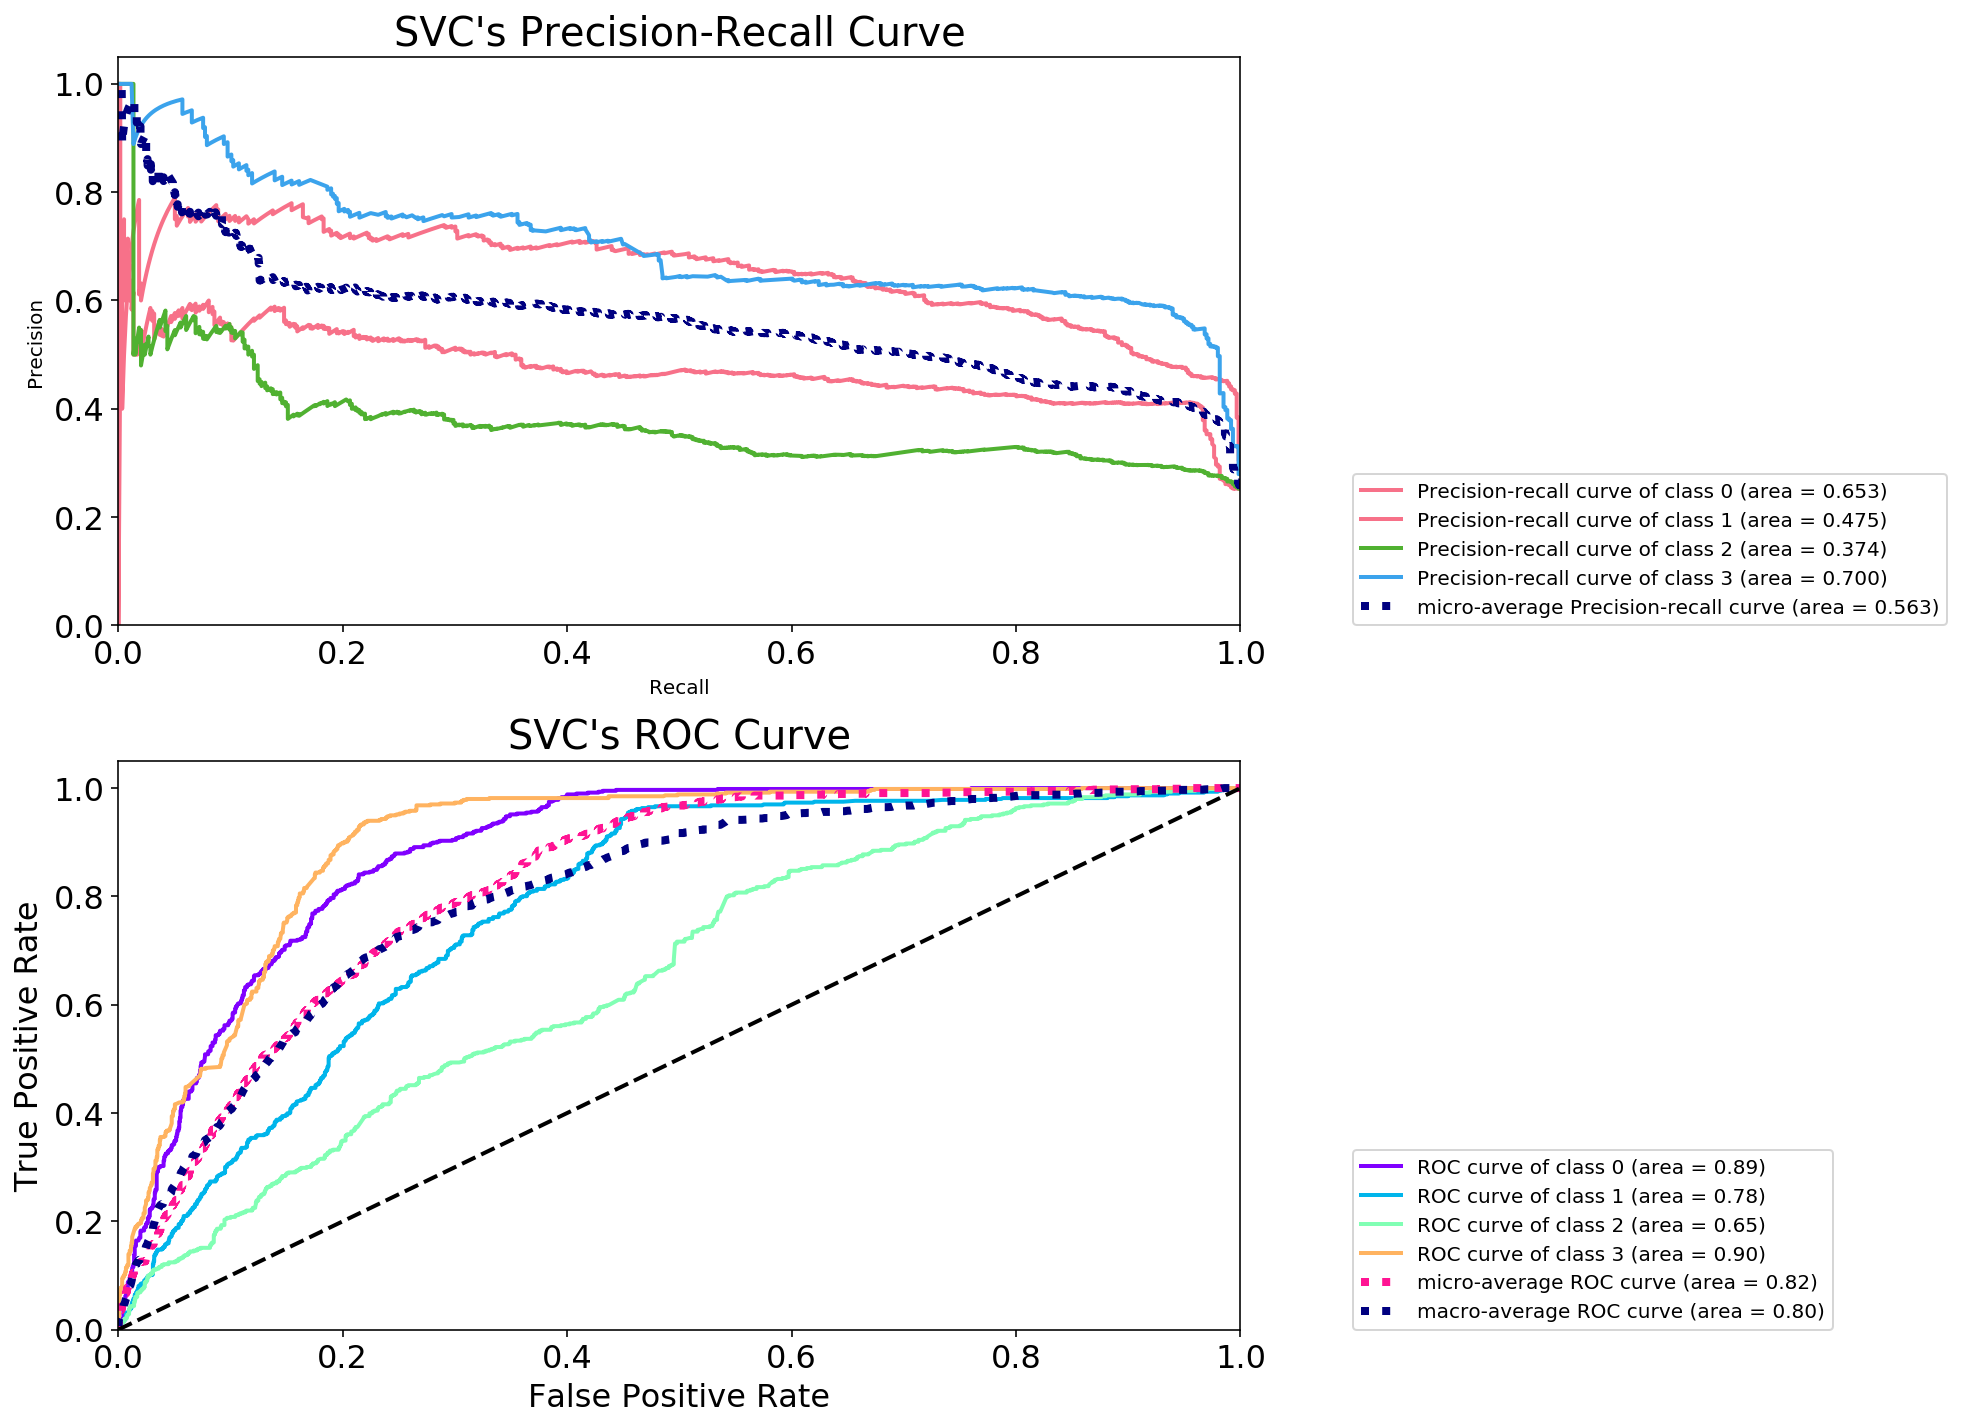

In [142]:
#Rerun SVC with proba = True in very above to run this:

fig, ax = plt.subplots(2, 1, figsize = (14, 10))

skplt.metrics.plot_precision_recall(yc_test, top_clf.Params[1].predict_proba(test_clX), 
                       plot_micro=True, title = "SVC's Precision-Recall Curve",
                       title_fontsize=20, text_fontsize=16, cmap=cmap, ax=ax[0])
ax[0].legend(loc=[1.1, 0])


skplt.metrics.plot_roc(yc_test, top_clf.Params[1].predict_proba(test_clX), plot_micro=True, plot_macro=True,
                       title = "SVC's ROC Curve",
    title_fontsize=20, text_fontsize=16, cmap= 'rainbow', ax = ax[1])

ax[1].legend(loc=[1.1,0])

#fig.suptitle("SVC's alternative scoring: \n", fontsize = 16)

plt.tight_layout()
plt.show()

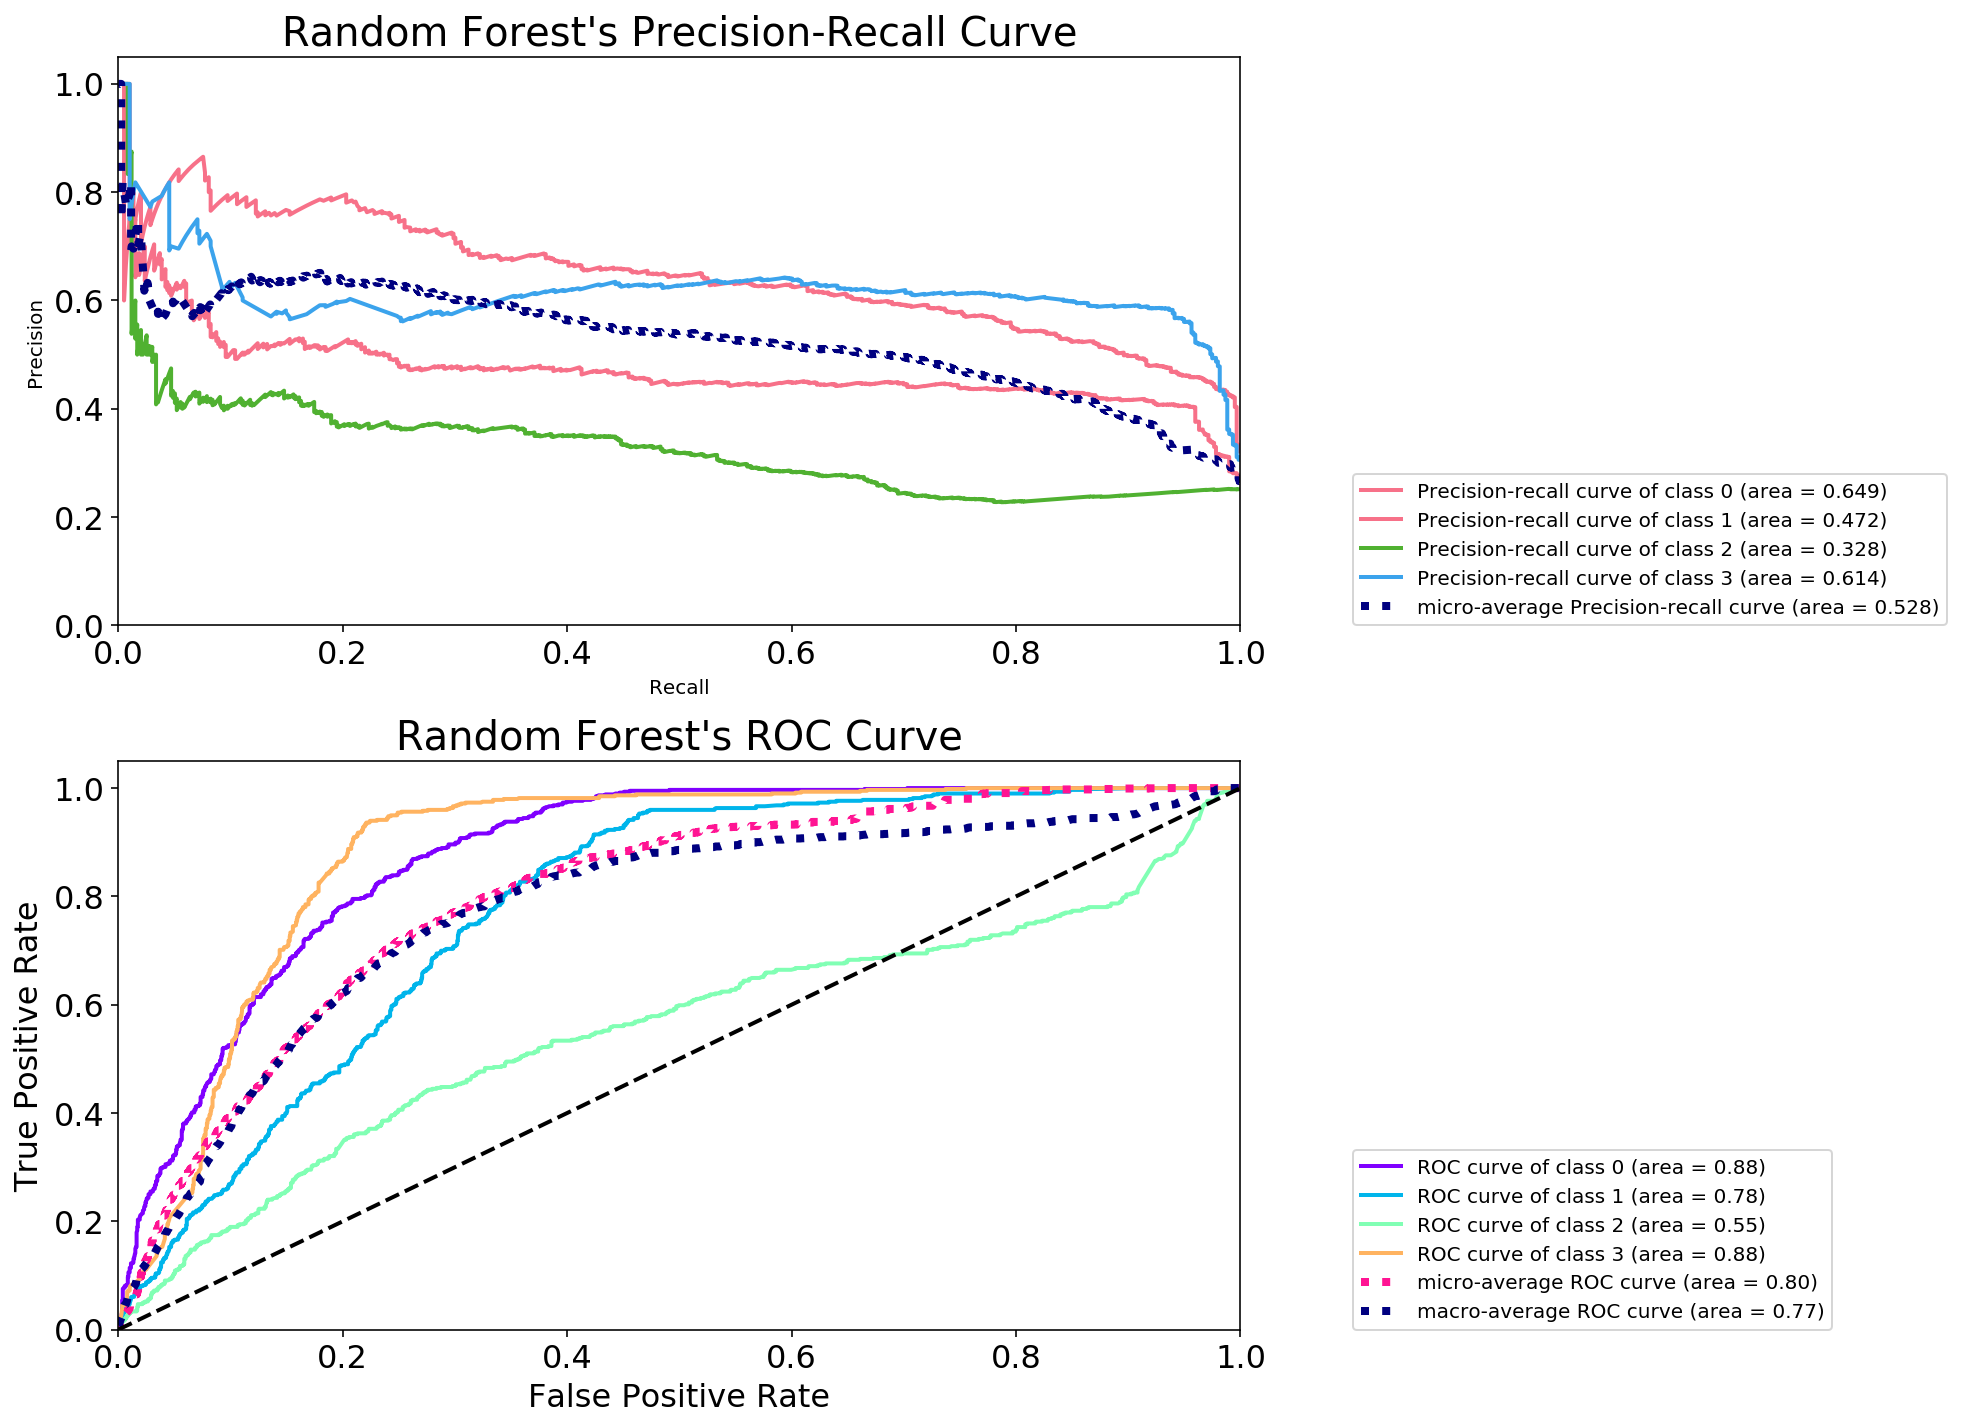

In [143]:
fig, ax = plt.subplots(2, 1, figsize = (14, 10))

skplt.metrics.plot_precision_recall(yc_test, top_clf.Params[2].predict_proba(test_clX), 
                       plot_micro=True, title = "Random Forest's Precision-Recall Curve",
                       title_fontsize=20, text_fontsize=16, cmap=cmap, ax=ax[0])
ax[0].legend(loc=[1.1, 0])


skplt.metrics.plot_roc(yc_test, top_clf.Params[2].predict_proba(test_clX), plot_micro=True, plot_macro=True,
                       title = "Random Forest's ROC Curve",
    title_fontsize=20, text_fontsize=16, cmap= 'rainbow', ax = ax[1])

ax[1].legend(loc=[1.1,0])

#fig.suptitle("SVC's alternative scoring: \n", fontsize = 16)

plt.tight_layout()
plt.show()

## Frosting features: bonus columns informing of certain measures' evolution:

In preparation for this model's rerun, I wanted to play with certain features to try optimizing the model's results. While I initially tinkered with time series, I soon realised I was lacking enough time values for a same country (about max 17 observations, one per year 2000-2017) for each country. 

In [263]:
X2.groupby(['Country', 'Date'])['gdp_g_anpc'].sum()

Country      Date
Afghanistan  2003    26.496833
             2005    33.689145
             2006    26.787016
             2007    69.131598
             2008    19.624919
                       ...    
Zimbabwe     2011    28.387826
             2013     3.978986
             2014     2.376929
             2016     2.267608
             2017    14.112106
Name: gdp_g_anpc, Length: 1482, dtype: float64

In [264]:
X4 = X2.copy()

In [265]:
X2.Date = pd.to_datetime(X2.Date)

In [266]:
X4.set_index('Date', drop=True, inplace=True)

In [267]:
X4.groupby(['Country', 'Date'])['gdp_g_anpc'].unique()

Country      Date
Afghanistan  2003      [8.83227780370231]
             2005      [11.2297148388595]
             2006      [5.35740324754602]
             2007      [13.8263195390595]
             2008      [3.92498382284521]
                             ...         
Zimbabwe     2011    [14.193912957216199]
             2013      [1.98949276207208]
             2014      [2.37692932698003]
             2016    [0.7558692509306009]
             2017      [4.70403534833559]
Name: gdp_g_anpc, Length: 1482, dtype: object

In [268]:
gdp_shift = pd.Series(X4.groupby(['Country','Date'])['gdp_g_anpc'].unique().shift())
gdp_shift

Country      Date
Afghanistan  2003                     NaN
             2005      [8.83227780370231]
             2006      [11.2297148388595]
             2007      [5.35740324754602]
             2008      [13.8263195390595]
                             ...         
Zimbabwe     2011      [12.0195599268985]
             2013    [14.193912957216199]
             2014      [1.98949276207208]
             2016      [2.37692932698003]
             2017    [0.7558692509306009]
Name: gdp_g_anpc, Length: 1482, dtype: object

In [293]:
gdp_df

gdp_g_anpc
Country     Date                      
Afghanistan 2003                   NaN
            2005    [8.83227780370231]
            2006    [11.2297148388595]
            2007    [5.35740324754602]
            2008    [13.8263195390595]
...                                ...
Zimbabwe    2011    [12.0195599268985]
            2013  [14.193912957216199]
            2014    [1.98949276207208]
            2016    [2.37692932698003]
            2017  [0.7558692509306009]

[1482 rows x 1 columns]

Nonetheless, borrowing timeseries' 'shifting' feature led me onto something. I settled with the creation of 3 additional columns informing of whether a project's country's GDP, GNI and Adjusted Net National Savings had grown, slowed or stayed the same from the year prior its having received the investment. 

In [359]:
gdp_shift = pd.Series(X4.groupby(['Country','Date'])['gdp_g_anpc'].unique().shift())
gdp_df = pd.DataFrame(gdp_shift) 
gdp_dir = []
for x in range(len(gdp_df.gdp_g_anpc)):
    if gdp_df.gdp_g_anpc[x] > gdp_df.gdp_g_anpc[x-1]:
        gdp_dir.append("GDP grew")
    elif gdp_df.gdp_g_anpc[x] < gdp_df.gdp_g_anpc[x-1]:
        gdp_dir.append("GDP slowed")
    else: 
        gdp_dir.append("Same GDP")
gdp_df['gdp_fluc'] = gdp_dir
gdp_df.reset_index(inplace=True)

In [364]:
X4.groupby(['Country', 'Date'])['gni_g_anpc'].unique()
gni_shift = pd.Series(X4.groupby(['Country','Date'])['gni_g_anpc'].unique().shift())
gni_df = pd.DataFrame(gni_shift)
gni_dir = []
for x in range(len(gni_df.gni_g_anpc)):
    if gni_df.gni_g_anpc[x] > gni_df.gni_g_anpc[x-1]:
        gni_dir.append("gni_grew")
    elif gni_df.gni_g_anpc[x] < gni_df.gni_g_anpc[x-1]:
        gni_dir.append("gni_slowed")
    else: 
        gni_dir.append("gni_same")
        
gni_df['gni_fluc'] = gni_dir

gni_df.reset_index(inplace=True)
gni_df

In [358]:
gni_df.reset_index(inplace=True)
gni_df

,index,Country,Date,gni_g_anpc,gni_fluc
0,0,Afghanistan,2003,NaN,gni_same
1,1,Afghanistan,2005,[4.222071172263272],gni_same
2,2,Afghanistan,2006,[4.222071172263272],gni_same
3,3,Afghanistan,2007,[4.222071172263272],gni_same
4,4,Afghanistan,2008,[4.222071172263272],gni_same
...,...,...,...,...,...
1477,1477,Zimbabwe,2011,[4.222071172263272],gni_same
1478,1478,Zimbabwe,2013,[11.888784286050301],gni_grew
1479,1479,Zimbabwe,2014,[5.63577247792119],gni_slowed
1480,1480,Zimbabwe,2016,[2.6741109172818702],gni_slowed


In [352]:
NS_df = pd.DataFrame(pd.Series(X4.groupby(['Country','Date'])['AdjNetNatSv_usd'].unique().shift()))
NS_df

AdjNetNatSv_usd
Country     Date                       
Afghanistan 2003                    NaN
            2005   [113296630190.56848]
            2006   [113296630190.56848]
            2007   [113296630190.56848]
            2008   [113296630190.56848]
...                                 ...
Zimbabwe    2011    [-1231651078.52804]
            2013    [-1177557794.03636]
            2014    [-2916343671.84055]
            2016    [-2575138166.69415]
            2017  [-2929812057.8495803]

[1482 rows x 1 columns]

In [356]:
NS_df.reset_index(inplace=True)


,Country,Date,AdjNetNatSv_usd,NS_fluc
0,Afghanistan,2003,NaN,NatSavs_same
1,Afghanistan,2005,[113296630190.56848],NatSavs_same
2,Afghanistan,2006,[113296630190.56848],NatSavs_same
3,Afghanistan,2007,[113296630190.56848],NatSavs_same
4,Afghanistan,2008,[113296630190.56848],NatSavs_same
...,...,...,...,...
1477,Zimbabwe,2011,[-1231651078.52804],NatSavs_slowed
1478,Zimbabwe,2013,[-1177557794.03636],NatSavs_grew
1479,Zimbabwe,2014,[-2916343671.84055],NatSavs_slowed
1480,Zimbabwe,2016,[-2575138166.69415],NatSavs_grew


In [353]:
ns_dir = []
for x in range(len(NS_df.AdjNetNatSv_usd)):
    if NS_df.AdjNetNatSv_usd[x] > NS_df.AdjNetNatSv_usd[x-1]:
        ns_dir.append("NatSavs_grew")
    elif NS_df.AdjNetNatSv_usd[x] < NS_df.AdjNetNatSv_usd[x-1]:
        ns_dir.append("NatSavs_slowed")
    else: 
        ns_dir.append("NatSavs_same")
        
NS_df['NS_fluc'] = ns_dir

After determining each of the three measures' fluctuations, I merge them in a single dataframe to save to a csv and upload in a new version of this notebook for the second run. 

In [360]:
add_fts = gdp_df.merge(gni_df, on = ['Country', 'Date'], how = 'left')
add_fts.head()

,Country,Date,gdp_g_anpc,gdp_fluc,index,gni_g_anpc,gni_fluc
0,Afghanistan,2003,NaN,Same GDP,0,NaN,gni_same
1,Afghanistan,2005,[8.83227780370231],Same GDP,1,[4.222071172263272],gni_same
2,Afghanistan,2006,[11.2297148388595],GDP grew,2,[4.222071172263272],gni_same
3,Afghanistan,2007,[5.35740324754602],GDP slowed,3,[4.222071172263272],gni_same
4,Afghanistan,2008,[13.8263195390595],GDP grew,4,[4.222071172263272],gni_same


In [361]:
add_fts = add_fts.merge(NS_df, on = ['Country', 'Date'], how = 'left')
add_fts.head()

,Country,Date,gdp_g_anpc,gdp_fluc,index,gni_g_anpc,gni_fluc,AdjNetNatSv_usd,NS_fluc
0,Afghanistan,2003,NaN,Same GDP,0,NaN,gni_same,NaN,NatSavs_same
1,Afghanistan,2005,[8.83227780370231],Same GDP,1,[4.222071172263272],gni_same,[113296630190.56848],NatSavs_same
2,Afghanistan,2006,[11.2297148388595],GDP grew,2,[4.222071172263272],gni_same,[113296630190.56848],NatSavs_same
3,Afghanistan,2007,[5.35740324754602],GDP slowed,3,[4.222071172263272],gni_same,[113296630190.56848],NatSavs_same
4,Afghanistan,2008,[13.8263195390595],GDP grew,4,[4.222071172263272],gni_same,[113296630190.56848],NatSavs_same


In [362]:
add_fts.drop(['gdp_g_anpc', 'gni_g_anpc', 'AdjNetNatSv_usd', 'index'], axis=1, inplace=True)

In [365]:
add_fts.drop(['gdp_g_anpc', 'gni_g_anpc', 'AdjNetNatSv_usd', 'index'], axis=1, inplace=True)
add_fts.to_csv('Engy_addfts.csv', index=False)

In [355]:
add_fts = pd.DataFrame()
add_fts['gdp_trend'] = gdp_dir
add_fts['gni_trend'] = gni_dir
add_fts['NatSavs_trend'] = ns_dir
add_fts.to_csv('Engy_addfts.csv', index=False)

## Scrap Code: Pre-Column Transformer's quest for optimal preprocessing method

Though the below code was discarded, I've left this trial as testimony of some of my research

In [ ]:
#From count vectorizer to transformer w/ tfidf using the vectorized variable X_all above
#Create 1 variable /parameter
#Create loop for model to iterate over mX > ranges, m/mx_df to try 
#Use 1 basic LogReg on MX ranges & THEN gridsearch
tfidf_transformer=TfidfTransformer(smooth_idf=True, use_idf=True)
tfidf_transformer.fit(X_train)
Pj_tfidf1= tfidf_transformer.transform(X_all)

In [ ]:
Pj_tfidf1.shape

In [ ]:
# print idf values
project_idf1 = pd.DataFrame(tfidf_transformer.idf_, index=cvec.get_feature_names(), columns=["idf_weights"])
 
# sort ascending
project_idf1.sort_values(by=['idf_weights'], ascending = False)

In [ ]:
#None of the below can run yet as no dummified X_csr yet: 
#Add above column to df1 in place of Project? Or need to Transpose it & stack? 
#1st transform to sparse matrix :
#Add 2 below to final DF:
#X_full1 = sc.sparse.hstack([X_csr, Pj_tfidf1])

In [188]:
pjs = FeatureExtractor('Project').transform(X_train, reshape=False)
countries[0]

array(['Afghanistan'], dtype=object)

In [195]:
### def fu_cols():

ct_pipe = make_pipeline(
    FeatureExtractor('Country'),
    OneHotEncoder(drop ='first')
)

date_pipe = make_pipeline(
    FeatureExtractor('Date'),
    OneHotEncoder(drop ='first')
)

inv_pipe = make_pipeline(
    FeatureExtractor('Investor'),
    OneHotEncoder(drop ='first')
)


tech_pipe = make_pipeline(
    FeatureExtractor('Technology'),
    OneHotEncoder(drop ='first')
)

asset_pipe = make_pipeline(
    FeatureExtractor('Asset Class'),
    OneHotEncoder(drop ='first')
)


tvec_pipe = Pipeline([
    ('feature extractor', FeatureExtractor('Project')), #, reshape=False
    ('tvec', TfidfVectorizer(use_idf=True, stop_words = stop, smooth_idf=True, strip_accents ='unicode')
)])

#pj_pipe = Pipeline

gdp_pipe = Pipeline([('feature extractor', FeatureExtractor('gdp_g_anpc'))])
gni_pipe = Pipeline([('feature extractor', FeatureExtractor('gni_g_anpc'))])
natsav_pipe = Pipeline([('feature extractor', FeatureExtractor('AdjNetNatSv_usd'))])
endep_pipe = Pipeline([('feature extractor', FeatureExtractor('AdjSav_Engdep_usd'))])
co2_pipe = Pipeline([('feature extractor', FeatureExtractor('AdjSav_CO2dmg_usd'))])
ptcl_pipe = Pipeline([('feature extractor', FeatureExtractor('AdjSav_Ptcldmg_pcGNI'))])
unemp_pipe = Pipeline([('feature extractor', FeatureExtractor('Unemp_pcLF'))])

#make one for each feature,

fu = FeatureUnion([("Country_pipe", ct_pipe),
                   ("Date_pipe", date_pipe),
                  ("Investor_pipe", inv_pipe), 
                  ("Technology_pipe",tech_pipe), 
                  ("Assetclass_pipe", asset_pipe), 
                  ("Project_pipe", tvec_pipe), 
                  ("GDP_pipe", gdp_pipe), 
                  ("GNI_pipe", gni_pipe),
                  ("AdjNetNatSavings_pipe", natsav_pipe),
                  ("AdjNS_EngDepletionpipe", endep_pipe),
                  ("AdjNS_co2_pipe", co2_pipe), 
                  ("AdjNS_ptclpipe", ptcl_pipe), 
                  ("Unemployment_pipe", unemp_pipe)])

#return fu

In [226]:
#fu.fit_transform(X_train)

In [ ]:
def get_freq_words(sparse_counts, columns):

    # X_all is a sparse matrix, so sum() returns a 'matrix' datatype ...
    #   which we then convert into a 1-D ndarray for sorting

    word_counts = np.ravel(X_all.sum(axis=0))
    freq_words = pd.Series(
        word_counts, index=columns).sort_values(ascending=False)

    return freq_words